In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [9]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [10]:
weather_station

Outdoor h Temperature (°F)  Wind Speed (mph)  \
Simple Date                                                         
2022-05-10 00:00:00                       55.74              0.00   
2022-05-10 01:00:00                       54.79              0.00   
2022-05-10 02:00:00                       53.88              0.00   
2022-05-10 03:00:00                       52.49              0.00   
2022-05-10 04:00:00                       51.70              0.00   
...                                         ...               ...   
2023-06-07 19:00:00                       80.57              0.02   
2023-06-07 20:00:00                       77.16              0.00   
2023-06-07 21:00:00                       74.54              0.00   
2023-06-07 22:00:00                       73.51              0.06   
2023-06-07 23:00:00                       72.15              0.00   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
Simple Date                                                  
2022-05-10 00:00:00             0.00                  0.00   
2022-05-10 01:00:00             0.00                  0.00   
2022-05-10 02:00:00             0.00                  0.00   
2022-05-10 03:00:00             0.00                  0.00   
2022-05-10 04:00:00             0.00                  0.00   
...                              ...                   ...   
2023-06-07 19:00:00             0.18                  9.20   
2023-06-07 20:00:00             0.00                  9.20   
2023-06-07 21:00:00             0.00                  9.20   
2023-06-07 22:00:00             0.09                  9.20   
2023-06-07 23:00:00             0.00                  9.20   

                     Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  \
Simple Date                                                                     
2022-05-10 00:00:00              305.17                 0.00             0.00   
2022-05-10 01:00:00              302.58                 0.00             0.00   
2022-05-10 02:00:00              298.92                 0.00             0.00   
2022-05-10 03:00:00              302.92                 0.00             0.00   
2022-05-10 04:00:00              305.17                 0.00             0.00   
...                                 ...                  ...              ...   
2023-06-07 19:00:00              287.08                 0.00             0.00   
2023-06-07 20:00:00              309.83                 0.00             0.00   
2023-06-07 21:00:00              304.83                 0.00             0.00   
2023-06-07 22:00:00              307.83                 0.00             0.00   
2023-06-07 23:00:00              306.58                 0.00             0.00   

                     Daily Rain (in)  Weekly Rain (in)  Monthly Rain (in)  \
Simple Date                                                                 
2022-05-10 00:00:00             0.00              0.00               0.76   
2022-05-10 01:00:00             0.00              0.00               0.76   
2022-05-10 02:00:00             0.00              0.00               0.76   
2022-05-10 03:00:00             0.00              0.00               0.76   
2022-05-10 04:00:00             0.00              0.00               0.76   
...                              ...               ...                ...   
2023-06-07 19:00:00             0.00              0.02               0.02   
2023-06-07 20:00:00             0.00              0.02               0.02   
2023-06-07 21:00:00             0.00              0.02               0.02   
2023-06-07 22:00:00             0.00              0.02               0.02   
2023-06-07 23:00:00             0.00              0.02               0.02   

                     Yearly Rain (in)  Relative Pressure (inHg)  Humidity (%)  \
Simple Date                                                                     
2022-05-10 00:00:00             22.72                     29.13         90.67   
2022-05-10 01:00:

In [11]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [12]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.05     37.00   7.36        88.00   
2022-05-11 20:00:00        30.05     41.00   6.93        83.00   
2022-05-11 21:00:00        30.06     45.00   6.52        80.00   
2022-05-11 22:00:00        30.07     49.00   6.12        77.00   
2022-05-11 23:00:00        30.10     50.00   5.73        76.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        29.89     57.50   9.67        77.00   
2023-06-06 09:00:00        29.89     57.00   9.14        79.00   
2023-06-06 10:00:00        29.90     49.00   8.69        86.00   
2023-06-06 11:00:00        29.79     47.00   8.26        78.00   
2023-06-06 12:00:00        30.02     68.00   7.81        74.00   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [13]:
df.dropna(inplace=True)

In [14]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.05     37.00   7.36        88.00   
2022-05-11 20:00:00        30.05     41.00   6.93        83.00   
2022-05-11 21:00:00        30.06     45.00   6.52        80.00   
2022-05-11 22:00:00        30.07     49.00   6.12        77.00   
2022-05-11 23:00:00        30.10     50.00   5.73        76.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        29.89     57.50   9.67        77.00   
2023-06-06 09:00:00        29.89     57.00   9.14        79.00   
2023-06-06 10:00:00        29.90     49.00   8.69        86.00   
2023-06-06 11:00:00        29.79     47.00   8.26        78.00   
2023-06-06 12:00:00        30.02     68.00   7.81        74.00   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [15]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [16]:
df.describe()

AirPressure  Humidity    Radon  Temperature  \
count     9,378.00  9,378.00 9,378.00     9,378.00   
mean         30.10     62.16    18.13        72.54   
std           0.14     13.24    20.50        17.99   
min          29.58     13.00    -0.61        15.00   
25%          30.01     54.04     0.87        60.00   
50%          30.10     63.00    12.20        74.00   
75%          30.19     72.00    29.45        82.55   
max          30.56     93.00   177.31       142.00   

       Outdoor h Temperature (°F)  Wind Speed (mph)  Wind Gust (mph)  \
count                    9,378.00          9,378.00         9,378.00   
mean                        62.98              0.23             0.90   
std                         14.85              0.37             1.15   
min                          7.12              0.00             0.00   
25%                         52.55              0.00             0.00   
50%                         64.87              0.03             0.37   
75%                         73.89              0.34             1.56   
max                         98.02              5.35             8.02   

       Max Daily Gust (mph)  Wind Direction (°)  Hourly Rain (in/hr)  ...  \
count              9,378.00            9,378.00             9,378.00  ...   
mean                   4.70              297.71                 0.01  ...   
std                    3.49               28.84                 0.04  ...   
min                    0.00                1.33                 0.00  ...   
25%                    1.48              289.00                 0.00  ...   
50%                    4.50              305.58                 0.00  ...   
75%                    6.90              316.08                 0.00  ...   
max                   20.60              347.67                 1.23  ...   

       Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
count          9,378.00           9,378.00          9,378.00   
mean               0.54               2.88             52.63   
std                0.85               2.98             18.94   
min                0.00               0.00             22.72   
25%                0.00               0.76             37.85   
50%                0.09               2.14             47.13   
75%                0.72               3.72             69.48   
max                3.90              14.68             83.42   

       Relative Pressure (inHg)  Humidity (%)  Ultra-Violet Radiation Index  \
count                  9,378.00      9,378.00                      9,378.00   
mean                      29.02         76.37                          0.96   
std                        0.14         17.72                          1.79   
min                       28.40         17.17                          0.00   
25%                       28.93         65.00                          0.00   
50%                       29.02         79.92                          0.00   
75%                       29.11         91.58                          1.00   
max                       29.51         99.00                          8.00   

       Solar Radiation (W/m^2)  Absolute Pressure (inHg)  \
count                 9,378.00                  9,378.00   
mean                    119.51                     29.02   
std                     200.38                      0.14   
min                       0.00                     28.40   
25%                       0.00                     28.93   
50%                       2.59                     29.02   
75%                     144.45                     29.11   
max                     872.65                     29.51   

       Avg Wind Direction (10 mins) (°)  Avg Wind Speed (10 mins) (mph)  
count                          9,378.00                        9,378.00  
mean                             308.30                            0.15  
std                               18.81                            0.31  
min                                1.42            

In [17]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [18]:
df.fillna(0, inplace=True)

In [40]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP.drop(["AirPressure", "Humidity","Temperature","Outdoor h Temperature (°F)","Wind Speed (mph)","Wind Gust (mph)","Max Daily Gust (mph)","Wind Direction (°)","Hourly Rain (in/hr)","Event Rain (in)","Daily Rain (in)","Weekly Rain (in)","Monthly Rain (in)","Yearly Rain (in)","Relative Pressure (inHg)","Humidity (%)","Ultra-Violet Radiation Index","Solar Radiation (W/m^2)","Absolute Pressure (inHg)","Avg Wind Direction (10 mins) (°)","Avg Wind Speed (10 mins) (mph)"], axis=0, inplace=True)
df_corrP

(841, 841)
correlation with Radon:


Radon
Radon                               1.00
Outdoor h Temperature (°F)_lag_26   0.60
Outdoor h Temperature (°F)_lag_25   0.60
Outdoor h Temperature (°F)_lag_27   0.60
Outdoor h Temperature (°F)_lag_24   0.60
...                                  ...
Yearly Rain (in)_lag_35            -0.61
Yearly Rain (in)_lag_36            -0.61
Yearly Rain (in)_lag_37            -0.61
Yearly Rain (in)_lag_38            -0.61
Yearly Rain (in)_lag_39            -0.61

[820 rows x 1 columns]

In [41]:
df_corrH = df_corrP.head(2)
df_corrH

Radon
Radon                               1.00
Outdoor h Temperature (°F)_lag_26   0.60

In [42]:
df4 = df[df_corrH.index]   # keep the components with at least modest correlations

In [43]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Radon                              9378 non-null   float32
 1   Outdoor h Temperature (°F)_lag_26  9378 non-null   float32
dtypes: float32(2)
memory usage: 146.5 KB


In [44]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [45]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)_lag_25']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Outdoor h Temperature (°F)_lag_26'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [25]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [26]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [27]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-06-06 12:00:00   0.05

In [28]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component            Outdoor h Temperature (°F)_lag_26
SyncDate                                              
2022-05-11 19:00:00                               0.00
2023-06-06 12:00:00                               0.70

In [29]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.04
2023-05-30 13:00:00   0.07

In [30]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nbeats_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"past": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
    if model_args['layer_widths'] == 'a':
        layer_widths = [64,64]
    elif model_args['layer_widths'] == 'b':
        layer_widths = [128,128]
    elif model_args['layer_widths'] == 'c':
        layer_widths = [256,256]
    elif model_args['layer_widths'] == 'd':
        layer_widths = [64,128]
    elif model_args['layer_widths'] == 'e':
        layer_widths = [128,256]
    elif model_args['layer_widths'] == 'f':
        layer_widths = [256,512]
    elif model_args['layer_widths'] == 'g':
        layer_widths = [64, 256]

    model = NBEATSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NBEATS",
        generic_architecture = True,
        num_stacks=2,
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        layer_widths = layer_widths,
        expansion_coefficient_dim = model_args['expansion_coefficient_dim'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                past_covariates=covF_t,
                val_series=val_series,
                val_past_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                past_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [31]:
def build_fit_nbeats_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"past": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
    
    if model_args['layer_widths'] == 'a':
        layer_widths = [64,64]
    elif model_args['layer_widths'] == 'b':
        layer_widths = [128,128]
    elif model_args['layer_widths'] == 'c':
        layer_widths = [256,256]
    elif model_args['layer_widths'] == 'd':
        layer_widths = [64,128]
    elif model_args['layer_widths'] == 'e':
        layer_widths = [128,256]
    elif model_args['layer_widths'] == 'f':
        layer_widths = [256,512]
    elif model_args['layer_widths'] == 'g':
        layer_widths = [64, 256]

    model = NBEATSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NBEATS",
        generic_architecture = True,
        num_stacks=2,
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        layer_widths =layer_widths,
        expansion_coefficient_dim = model_args['expansion_coefficient_dim'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                past_covariates=covF_t,
                val_series=val_series,
                val_past_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [32]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,30),
    "out_len":tune.randint(1,4),
    "batch_size":tune.choice([32,64,128,256]),
    "num_blocks": tune.randint(1,10),
    "num_layers":tune.randint(1,5),
    "layer_widths":tune.choice(['a','b','c','d','e','f','g']),
    "expansion_coefficient_dim":tune.randint(10, 50),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU','Sigmoid']),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nbeats_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="nbeats_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 16:54:13 (running for 00:00:00.15)
Memory usage on this node: 25.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 1/100 (1 RUNNING)
+---------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------------+----------------+
| Trial name                      | status   | loc                  |   in_len |   out_len |   batch_size |   num_blocks |   num_layers | layer_widths   |   expansion_coefficien |   dropout | activation   |          lr | include_hour   |
|                                 |          |                      |    

(build_fit_nbeats_model pid=1432489) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1432489)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1432489) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1432489)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1432489) Auto select gpus: [0]
(build_fit_nbeats_model pid=1432489) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1432489) TPU a

== Status ==
Current time: 2023-07-08 16:54:23 (running for 00:00:09.81)
Memory usage on this node: 33.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+---------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------------+----------------+
| Trial name                      | status   | loc                  |   in_len |   out_len |   batch_size |   num_blocks |   num_layers | layer_widths   |   expansion_coefficien |   dropout | activation   |          lr | include_hour   |
|                                 |          |

(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433054) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

(build_fit_nbeats_model pid=1433041) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433105) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433105) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433105) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1433105) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1433105) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1433105) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1433050) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433050) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433050) TPU available: False,

(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1433044)   rank_zero_warn(
(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1433044)   rank_zero_warn(
(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 16:54:28 (running for 00:00:14.84)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+---------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------------+----------------+
| Trial name                      | status   | loc                  |   in_len |   out_len |   batch_size |   num_blocks |   num_layers | layer_widths   |   expansion_coefficien |   dropout | activation   |          lr | include_hour   |
|                                 |          |

(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433044) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433044) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433044) TPU a

(build_fit_nbeats_model pid=1433044) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s]


(build_fit_nbeats_model pid=1433041) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433041) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433041) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1433041) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1433041) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1433041) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1433041) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.93it/s]


(build_fit_nbeats_model pid=1432489) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1432489)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1432489) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1432489)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1432489) Auto select gpus: [0]
(build_fit_nbeats_model pid=1432489) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1432489) TPU a

(build_fit_nbeats_model pid=1435354) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1435354)   rank_zero_warn(
(build_fit_nbeats_model pid=1435354) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1435354)   rank_zero_warn(
(build_fit_nbeats_model pid=1435669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use 

== Status ==
Current time: 2023-07-08 16:54:42 (running for 00:00:29.43)
Memory usage on this node: 44.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: de8367db with q_smape=104.48527336120605 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 'f', 'expansion_coefficient_dim': 15, 'dropout': 0.16157516598847438, 'activation': 'Sigmoid', 'lr': 0.0009370219109446862, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-------

(build_fit_nbeats_model pid=1435669) Auto select gpus: [0]
(build_fit_nbeats_model pid=1435669) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1435669) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1435669) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1435669) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1435669) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1435669) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1435669) 
(build_fit_nbeats_model pid=1435669)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1435669) ---------------

== Status ==
Current time: 2023-07-08 16:54:47 (running for 00:00:34.43)
Memory usage on this node: 42.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: de8367db with q_smape=104.48527336120605 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 'f', 'expansion_coefficient_dim': 15, 'dropout': 0.16157516598847438, 'activation': 'Sigmoid', 'lr': 0.0009370219109446862, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-------

(build_fit_nbeats_model pid=1433047) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433047)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433047) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433047)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433047) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433047) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433047) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1433050) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433050)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433050) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433050)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433050) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433050) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433050) TPU a

(build_fit_nbeats_model pid=1433050) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


(build_fit_nbeats_model pid=1435354) Auto select gpus: [0]
(build_fit_nbeats_model pid=1435354) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1435354) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1435354) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1435354) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1435354) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1435354) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1436699)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1436699)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:54:56 (running for 00:00:43.47)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9271aa4b with q_smape=62.36129403114319 and parameters={'in_len': 21, 'out_len': 2, 'batch_size': 256, 'num_blocks': 5, 'num_layers': 1, 'layer_widths': 'c', 'expansion_coefficient_dim': 28, 'dropout': 0.3795040674098721, 'activation': 'ReLU', 'lr': 0.0027486679280695606, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1437061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1437061)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1437061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1437061)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1436699) Auto select gpus: [0]
(build_fit_nbeats_model pid=1436699) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1436699) TPU a

== Status ==
Current time: 2023-07-08 16:55:02 (running for 00:00:49.42)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9271aa4b with q_smape=62.36129403114319 and parameters={'in_len': 21, 'out_len': 2, 'batch_size': 256, 'num_blocks': 5, 'num_layers': 1, 'layer_widths': 'c', 'expansion_coefficient_dim': 28, 'dropout': 0.3795040674098721, 'activation': 'ReLU', 'lr': 0.0027486679280695606, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1437396) Auto select gpus: [0]
(build_fit_nbeats_model pid=1437396) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1437396) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1437396) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1437396) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1437396) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1437396) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1437396) 
(build_fit_nbeats_model pid=1437396)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1437396) ---------------

== Status ==
Current time: 2023-07-08 16:55:07 (running for 00:00:54.44)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9271aa4b with q_smape=62.36129403114319 and parameters={'in_len': 21, 'out_len': 2, 'batch_size': 256, 'num_blocks': 5, 'num_layers': 1, 'layer_widths': 'c', 'expansion_coefficient_dim': 28, 'dropout': 0.3795040674098721, 'activation': 'ReLU', 'lr': 0.0027486679280695606, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1433054) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433054)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433054) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433054)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433054) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433054) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433054) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1433056) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433056) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433056) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1433056) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1433056) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1433056) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1433056) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1433056) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


(build_fit_nbeats_model pid=1433056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nbeats_model pid=1433056)   X /= self.scale_
(build_fit_nbeats_model pid=1433056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nbeats_model pid=1433056)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1436699)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nbeats_model pid=1436699)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nbeats_model pid=1436699) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nbeats_model pid=1436699)   ret = ret.dtype.type(ret / rcount)


== Status ==
Current time: 2023-07-08 16:55:18 (running for 00:01:04.86)
Memory usage on this node: 40.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e8857586 with q_smape=29.891905188560486 and parameters={'in_len': 20, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 'a', 'expansion_coefficient_dim': 49, 'dropout': 0.2560177767239432, 'activation': 'SELU', 'lr': 9.554657726628455e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 16/100 (1 PENDING, 8 RUNNING, 7 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+----------

(build_fit_nbeats_model pid=1438057) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1438057)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1438057) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1438057)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1438057) Auto select gpus: [0]
(build_fit_nbeats_model pid=1438057) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1438057) TPU a

== Status ==
Current time: 2023-07-08 16:55:27 (running for 00:01:14.44)
Memory usage on this node: 39.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e8857586 with q_smape=29.891905188560486 and parameters={'in_len': 20, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 'a', 'expansion_coefficient_dim': 49, 'dropout': 0.2560177767239432, 'activation': 'SELU', 'lr': 9.554657726628455e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+----------

(build_fit_nbeats_model pid=1438605) Auto select gpus: [0]
(build_fit_nbeats_model pid=1438605) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1438605) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1438605) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1438605) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1438605) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1438605) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1438605) 
(build_fit_nbeats_model pid=1438605)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1438605) ---------------

== Status ==
Current time: 2023-07-08 16:55:32 (running for 00:01:19.46)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e8857586 with q_smape=29.891905188560486 and parameters={'in_len': 20, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 2, 'layer_widths': 'a', 'expansion_coefficient_dim': 49, 'dropout': 0.2560177767239432, 'activation': 'SELU', 'lr': 9.554657726628455e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+----------

(build_fit_nbeats_model pid=1433105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1433105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1433105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1433105) Auto select gpus: [0]
(build_fit_nbeats_model pid=1433105) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1433105) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


(build_fit_nbeats_model pid=1435028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1435028)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1435028) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1435028)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1435028) Auto select gpus: [0]
(build_fit_nbeats_model pid=1435028) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1435028) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


(build_fit_nbeats_model pid=1439568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1439568)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1439568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1439568)   rank_zero_deprecation(


(build_fit_nbeats_model pid=1437396) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1437396) Auto select gpus: [0]
(build_fit_nbeats_model pid=1437396) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1437396) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1437396) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1437396) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1437396) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1437396) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1437396) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]== Status ==
Current time: 2023-07-08 16:55:40 (running for 00:01:27.16)
Memory usage on this node: 42.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 20/100 (1 PENDING, 8 RUNNING, 11 TERMINATED)
+---------------------------------+------------+----------------------+----------

(build_fit_nbeats_model pid=1439823) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1439823)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1439823) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1439823)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1439568) Auto select gpus: [0]
(build_fit_nbeats_model pid=1439568) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1439568) TPU a

== Status ==
Current time: 2023-07-08 16:55:45 (running for 00:01:32.46)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1440259) Auto select gpus: [0]
(build_fit_nbeats_model pid=1440259) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1440259) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1440259) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1440259) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1440259) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1440259) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1440259) 
(build_fit_nbeats_model pid=1440259)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1440259) ---------------

(build_fit_nbeats_model pid=1439823) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1439823) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


(build_fit_nbeats_model pid=1439823) Auto select gpus: [0]
(build_fit_nbeats_model pid=1439823) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1439823) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1439823) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1439823) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1439823) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1439823) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1437061) Auto select gpus: [0]
(build_fit_nbeats_model pid=1437061) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1437061) T

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
== Status ==
Current time: 2023-07-08 16:55:54 (running for 00:01:41.38)
Memory usage on this node: 42.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+---------

(build_fit_nbeats_model pid=1441014) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1441014)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1441014) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1441014)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1441014) Auto select gpus: [0]
(build_fit_nbeats_model pid=1441014) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1441014) TPU a

== Status ==
Current time: 2023-07-08 16:56:00 (running for 00:01:47.46)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1441453) Auto select gpus: [0]
(build_fit_nbeats_model pid=1441453) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1441453) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1441453) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1441453) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1441453) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1441453) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1441453) 
(build_fit_nbeats_model pid=1441453)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1441453) ---------------

== Status ==
Current time: 2023-07-08 16:56:05 (running for 00:01:52.47)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:56:15 (running for 00:02:02.49)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1438057) Auto select gpus: [0]
(build_fit_nbeats_model pid=1438057) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1438057) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1438057) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1438057) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1438057) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1438057) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1438057) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


(build_fit_nbeats_model pid=1442183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1442183)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1442183)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:56:22 (running for 00:02:09.47)
Memory usage on this node: 44.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1438605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1438605)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1438605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1438605)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1438605) Auto select gpus: [0]


(build_fit_nbeats_model pid=1438605) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


(build_fit_nbeats_model pid=1438605) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1438605) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1438605) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1438605) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1438605) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1438605) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1442183) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442183) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442183) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_m

== Status ==
Current time: 2023-07-08 16:56:28 (running for 00:02:15.45)
Memory usage on this node: 42.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 25/100 (1 PENDING, 8 RUNNING, 16 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1442417) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442417) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442417) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1442417) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1442417) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1442417) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1442417) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1442417) 
(build_fit_nbeats_model pid=1442417)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1442417) ---------------

(build_fit_nbeats_model pid=1439568) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


(build_fit_nbeats_model pid=1439568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1442903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1442903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1442903)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:56:38 (running for 00:02:25.46)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1442903) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442903) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442903) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1442903) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1442903) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1442903) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1442903) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1442903) 
(build_fit_nbeats_model pid=1442903)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1442903) ---------------

== Status ==
Current time: 2023-07-08 16:56:43 (running for 00:02:30.48)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d8c182d8 with q_smape=26.24954581260681 and parameters={'in_len': 13, 'out_len': 2, 'batch_size': 128, 'num_blocks': 7, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 42, 'dropout': 0.4971059759137063, 'activation': 'PReLU', 'lr': 0.00017005523032860294, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 26/100 (1 PENDING, 8 RUNNING, 17 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1440259) Auto select gpus: [0]
(build_fit_nbeats_model pid=1440259) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1440259) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1440259) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1440259) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1440259) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1440259) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1440259) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


(build_fit_nbeats_model pid=1443378) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1443378)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1443378) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1443378)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:56:52 (running for 00:02:39.46)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c70db7cc with q_smape=22.245925664901733 and parameters={'in_len': 13, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 17, 'dropout': 0.3636117688917516, 'activation': 'ReLU', 'lr': 0.0002380774516466856, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1443378) Auto select gpus: [0]
(build_fit_nbeats_model pid=1443378) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1443378) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1443378) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1443378) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1443378) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1443378) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1443378) 
(build_fit_nbeats_model pid=1443378)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1443378) ---------------

== Status ==
Current time: 2023-07-08 16:56:57 (running for 00:02:44.48)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c70db7cc with q_smape=22.245925664901733 and parameters={'in_len': 13, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 17, 'dropout': 0.3636117688917516, 'activation': 'ReLU', 'lr': 0.0002380774516466856, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1442903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1442903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1442903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442903) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442903) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442903) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


(build_fit_nbeats_model pid=1443622) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1443622)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1443622) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1443622)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:57:06 (running for 00:02:53.47)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c70db7cc with q_smape=22.245925664901733 and parameters={'in_len': 13, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 17, 'dropout': 0.3636117688917516, 'activation': 'ReLU', 'lr': 0.0002380774516466856, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1443622) Auto select gpus: [0]
(build_fit_nbeats_model pid=1443622) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1443622) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1443622) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1443622) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1443622) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1443622) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1443622) 
(build_fit_nbeats_model pid=1443622)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1443622) ---------------

== Status ==
Current time: 2023-07-08 16:57:11 (running for 00:02:58.48)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c70db7cc with q_smape=22.245925664901733 and parameters={'in_len': 13, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 17, 'dropout': 0.3636117688917516, 'activation': 'ReLU', 'lr': 0.0002380774516466856, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:57:21 (running for 00:03:08.50)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c70db7cc with q_smape=22.245925664901733 and parameters={'in_len': 13, 'out_len': 3, 'batch_size': 128, 'num_blocks': 1, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 17, 'dropout': 0.3636117688917516, 'activation': 'ReLU', 'lr': 0.0002380774516466856, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 28/100 (1 PENDING, 8 RUNNING, 19 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1435669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1435669)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1435669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1435669)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1435669) Auto select gpus: [0]
(build_fit_nbeats_model pid=1435669) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1435669) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


(build_fit_nbeats_model pid=1442417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1442417)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442417) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1442417)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442417) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442417) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442417) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


(build_fit_nbeats_model pid=1443868) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1443868)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1443868) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1443868)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444030) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 16:57:29 (running for 00:03:16.48)
Memory usage on this node: 44.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1443868) Auto select gpus: [0]
(build_fit_nbeats_model pid=1443868) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1443868) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1443868) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1443868) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1443868) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1443868) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1443868) 
(build_fit_nbeats_model pid=1443868)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1443868) ---------------

(build_fit_nbeats_model pid=1443378) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1443378) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1443378) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


(build_fit_nbeats_model pid=1438602) Auto select gpus: [0]
(build_fit_nbeats_model pid=1438602) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1438602) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1438602) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1438602) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1438602) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1438602) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
== Status ==
Current time: 2023-07-08 16:57:38 (running for 00:03:25.04)
Memory usage on this node: 44.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+---------

(build_fit_nbeats_model pid=1444347) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1444347)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444347) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1444347)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444347) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444347) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444347) TPU a

== Status ==
Current time: 2023-07-08 16:57:44 (running for 00:03:31.49)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1444582) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444582) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444582) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1444582) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1444582) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1444582) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1444582) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1444582) 
(build_fit_nbeats_model pid=1444582)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1444582) ---------------

== Status ==
Current time: 2023-07-08 16:57:49 (running for 00:03:36.51)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:57:59 (running for 00:03:46.53)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 32/100 (1 PENDING, 8 RUNNING, 23 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1442183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1442183)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1442183)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1442183) Auto select gpus: [0]
(build_fit_nbeats_model pid=1442183) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1442183) TPU a

(build_fit_nbeats_model pid=1442183) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1442183) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1442183) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


(build_fit_nbeats_model pid=1444835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1444835)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1444835)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:58:08 (running for 00:03:55.48)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1444835) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444835) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444835) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1444835) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1444835) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1444835) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1444835) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1444835) 
(build_fit_nbeats_model pid=1444835)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1444835) ---------------

== Status ==
Current time: 2023-07-08 16:58:13 (running for 00:04:00.49)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:58:23 (running for 00:04:10.51)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:58:33 (running for 00:04:20.54)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1444030) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444030) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444030) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1444030) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1444030) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1444030) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1444030) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


(build_fit_nbeats_model pid=1445327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1445327)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1445327)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:58:42 (running for 00:04:29.48)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1445327) Auto select gpus: [0]
(build_fit_nbeats_model pid=1445327) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1445327) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1445327) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1445327) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1445327) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1445327) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1445327) 
(build_fit_nbeats_model pid=1445327)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1445327) ---------------

== Status ==
Current time: 2023-07-08 16:58:47 (running for 00:04:34.49)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:58:57 (running for 00:04:44.51)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:59:07 (running for 00:04:54.54)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1443622) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1443622)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1443622) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1443622)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1443622) Auto select gpus: [0]
(build_fit_nbeats_model pid=1443622) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1443622) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 16:59:12 (running for 00:04:59.56)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d6b95228 with q_smape=14.180326461791992 and parameters={'in_len': 26, 'out_len': 2, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 23, 'dropout': 0.34572378406702287, 'activation': 'Tanh', 'lr': 0.00023984350635863666, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--

(build_fit_nbeats_model pid=1445815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1445815)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1445815)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:59:18 (running for 00:05:05.48)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1445815) Auto select gpus: [0]
(build_fit_nbeats_model pid=1445815) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1445815) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1445815) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1445815) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1445815) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1445815) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1445815) 
(build_fit_nbeats_model pid=1445815)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1445815) ---------------

== Status ==
Current time: 2023-07-08 16:59:23 (running for 00:05:10.50)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 16:59:33 (running for 00:05:20.52)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1444582) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1444582) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444582) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444582) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1444582) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1444582) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1444582) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1444582) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(build_fit_nbeats_model pid=1444582) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


(build_fit_nbeats_model pid=1446741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1446741)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1446741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1446741)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 16:59:48 (running for 00:05:35.49)
Memory usage on this node: 44.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1446741) Auto select gpus: [0]
(build_fit_nbeats_model pid=1446741) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1446741) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1446741) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1446741) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1446741) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1446741) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1446741) 
(build_fit_nbeats_model pid=1446741)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1446741) ---------------

== Status ==
Current time: 2023-07-08 16:59:53 (running for 00:05:40.50)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1444347) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444347) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444347) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1444347) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1444347) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1444347) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1444347) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
== Status ==
Current time: 2023-07-08 16:59:59 (running for 00:05:46.47)
Memory usage on this node: 44.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 36/100 (8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+-----

(build_fit_nbeats_model pid=1447069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1447069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1447069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1447069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1447069) Auto select gpus: [0]
(build_fit_nbeats_model pid=1447069) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1447069) TPU a

== Status ==
Current time: 2023-07-08 17:00:09 (running for 00:05:56.11)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:00:19 (running for 00:06:06.13)
Memory usage on this node: 44.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:00:29 (running for 00:06:16.16)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:00:39 (running for 00:06:26.18)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:00:49 (running for 00:06:36.20)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:00:59 (running for 00:06:46.23)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:01:09 (running for 00:06:56.25)
Memory usage on this node: 46.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 37/100 (1 PENDING, 8 RUNNING, 28 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1446741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1446741)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1446741) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1446741)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1446741) Auto select gpus: [0]
(build_fit_nbeats_model pid=1446741) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1446741) TPU a

(build_fit_nbeats_model pid=1446741) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


(build_fit_nbeats_model pid=1445327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1445327)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445327) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1445327)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445327) Auto select gpus: [0]
(build_fit_nbeats_model pid=1445327) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1445327) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(build_fit_nbeats_model pid=1448760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1448760)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1448760)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448760) Auto select gpus: [0]
(build_fit_nbeats_model pid=1448760) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1448760) TPU a

== Status ==
Current time: 2023-07-08 17:01:14 (running for 00:07:01.48)
Memory usage on this node: 42.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 38/100 (8 RUNNING, 30 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

(build_fit_nbeats_model pid=1448923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1448923)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1448923)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448923) Auto select gpus: [0]
(build_fit_nbeats_model pid=1448923) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1448923) TPU a

== Status ==
Current time: 2023-07-08 17:01:24 (running for 00:07:11.13)
Memory usage on this node: 45.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1445815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1445815)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1445815)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1445815) Auto select gpus: [0]
(build_fit_nbeats_model pid=1445815) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1445815) TPU a

(build_fit_nbeats_model pid=1445815) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1445815) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
== Status ==
Current time: 2023-07-08 17:01:37 (running for 00:07:24.51)
Memory usage on this node: 42.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+---------

(build_fit_nbeats_model pid=1449643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1449643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1449643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1449643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1449643) Auto select gpus: [0]
(build_fit_nbeats_model pid=1449643) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1449643) TPU a

(build_fit_nbeats_model pid=1441014) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1441014) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(build_fit_nbeats_model pid=1441014) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


(build_fit_nbeats_model pid=1450204) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1450204)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1450204) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1450204)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:01:47 (running for 00:07:34.50)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1450204) Auto select gpus: [0]
(build_fit_nbeats_model pid=1450204) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1450204) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1450204) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1450204) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1450204) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1450204) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1450204) 
(build_fit_nbeats_model pid=1450204)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1450204) ---------------

== Status ==
Current time: 2023-07-08 17:01:52 (running for 00:07:39.52)
Memory usage on this node: 44.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:02:02 (running for 00:07:49.54)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:02:12 (running for 00:07:59.57)
Memory usage on this node: 45.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:02:22 (running for 00:08:09.59)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1449643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1449643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1449643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1449643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1449643) Auto select gpus: [0]
(build_fit_nbeats_model pid=1449643) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1449643) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


(build_fit_nbeats_model pid=1451167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1451167)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1451167)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:02:31 (running for 00:08:18.52)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1451167) Auto select gpus: [0]
(build_fit_nbeats_model pid=1451167) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1451167) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1451167) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1451167) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1451167) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1451167) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1451167) 
(build_fit_nbeats_model pid=1451167)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1451167) ---------------

== Status ==
Current time: 2023-07-08 17:02:36 (running for 00:08:23.54)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:02:46 (running for 00:08:33.56)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1447069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1447069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1447069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1447069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1447069) Auto select gpus: [0]
(build_fit_nbeats_model pid=1447069) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1447069) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


(build_fit_nbeats_model pid=1451655) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1451655)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451655) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1451655)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:03:01 (running for 00:08:48.54)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1451655) Auto select gpus: [0]
(build_fit_nbeats_model pid=1451655) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1451655) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1451655) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1451655) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1451655) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1451655) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1451655) 
(build_fit_nbeats_model pid=1451655)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1451655) ---------------

== Status ==
Current time: 2023-07-08 17:03:06 (running for 00:08:53.55)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1451655) Auto select gpus: [0]
(build_fit_nbeats_model pid=1451655) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1451655) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1451655) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1451655) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1451655) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1451655) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


(build_fit_nbeats_model pid=1451655) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nbeats_model pid=1451655)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nbeats_model pid=1451655) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nbeats_model pid=1451655)   ret = ret.dtype.type(ret / rcount)
(build_fit_nbeats_model pid=1451167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1451167)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451167) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connector

(build_fit_nbeats_model pid=1451167) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1448923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1448923)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448923) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1448923)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448923) Auto select gpus: [0]
(build_fit_nbeats_model pid=1448923) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1448923) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


(build_fit_nbeats_model pid=1451903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1451903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1451903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:03:16 (running for 00:09:03.57)
Memory usage on this node: 40.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1451903) Auto select gpus: [0]
(build_fit_nbeats_model pid=1451903) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1451903) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1451903) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1451903) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1451903) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1451903) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1451903) 
(build_fit_nbeats_model pid=1451903)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1451903) ---------------

== Status ==
Current time: 2023-07-08 17:03:21 (running for 00:09:08.59)
Memory usage on this node: 46.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1443868) Auto select gpus: [0]
(build_fit_nbeats_model pid=1443868) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1443868) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1443868) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1443868) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1443868) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


(build_fit_nbeats_model pid=1443868) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1443868) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1443868) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


(build_fit_nbeats_model pid=1452856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1452856)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1452856)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:03:28 (running for 00:09:15.53)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1452856) Auto select gpus: [0]
(build_fit_nbeats_model pid=1452856) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1452856) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1452856) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1452856) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1452856) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1452856) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1452856) 
(build_fit_nbeats_model pid=1452856)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1452856) ---------------

== Status ==
Current time: 2023-07-08 17:03:33 (running for 00:09:20.54)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:03:43 (running for 00:09:30.56)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:03:53 (running for 00:09:40.58)
Memory usage on this node: 42.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1450204) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1450204)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1450204) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1450204)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1450204) Auto select gpus: [0]
(build_fit_nbeats_model pid=1450204) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1450204) TPU a

== Status ==
Current time: 2023-07-08 17:03:58 (running for 00:09:45.60)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1451903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1451903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451903) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1451903)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1451903) Auto select gpus: [0]
(build_fit_nbeats_model pid=1451903) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1451903) TPU a

(build_fit_nbeats_model pid=1451903) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1451903) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1451903) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


(build_fit_nbeats_model pid=1453822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1453822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1453822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453822) Auto select gpus: [0]
(build_fit_nbeats_model pid=1453822) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1453822) TPU a

== Status ==
Current time: 2023-07-08 17:04:08 (running for 00:09:55.54)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1453987) Auto select gpus: [0]
(build_fit_nbeats_model pid=1453987) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1453987) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1453987) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1453987) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1453987) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1453987) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1453987) 
(build_fit_nbeats_model pid=1453987)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1453987) ---------------

== Status ==
Current time: 2023-07-08 17:04:13 (running for 00:10:00.56)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:04:23 (running for 00:10:10.59)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:04:33 (running for 00:10:20.61)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:04:43 (running for 00:10:30.64)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:04:53 (running for 00:10:40.66)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:05:03 (running for 00:10:50.68)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 5fa063a1 with q_smape=10.579966008663177 and parameters={'in_len': 15, 'out_len': 1, 'batch_size': 128, 'num_blocks': 9, 'num_layers': 4, 'layer_widths': 'e', 'expansion_coefficient_dim': 44, 'dropout': 0.4856006743119274, 'activation': 'PReLU', 'lr': 0.0002398523670730791, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1448760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1448760)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448760) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1448760)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1448760) Auto select gpus: [0]
(build_fit_nbeats_model pid=1448760) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1448760) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


(build_fit_nbeats_model pid=1452071) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1452071)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452071) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1452071)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452071) Auto select gpus: [0]
(build_fit_nbeats_model pid=1452071) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1452071) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
== Status ==
Current time: 2023-07-08 17:05:10 (running for 00:10:57.64)
Memory usage on this node: 40.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1454822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1454822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1454822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1454822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1454822) Auto select gpus: [0]
(build_fit_nbeats_model pid=1454822) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1454822) TPU a

== Status ==
Current time: 2023-07-08 17:05:17 (running for 00:11:04.56)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1455295) Auto select gpus: [0]
(build_fit_nbeats_model pid=1455295) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1455295) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1455295) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1455295) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1455295) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1455295) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1455295) 
(build_fit_nbeats_model pid=1455295)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1455295) ---------------

== Status ==
Current time: 2023-07-08 17:05:22 (running for 00:11:09.58)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:05:32 (running for 00:11:19.60)
Memory usage on this node: 42.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 51/100 (1 PENDING, 8 RUNNING, 42 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1455295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1455295)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1455295) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1455295)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1455295) Auto select gpus: [0]
(build_fit_nbeats_model pid=1455295) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1455295) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


(build_fit_nbeats_model pid=1456100) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1456100)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456100) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1456100)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:05:47 (running for 00:11:34.55)
Memory usage on this node: 42.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1456100) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456100) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456100) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1456100) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1456100) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1456100) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1456100) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1456100) 
(build_fit_nbeats_model pid=1456100)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1456100) ---------------

== Status ==
Current time: 2023-07-08 17:05:52 (running for 00:11:39.57)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1444835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1444835)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444835) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1444835)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1444835) Auto select gpus: [0]
(build_fit_nbeats_model pid=1444835) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1444835) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


(build_fit_nbeats_model pid=1452856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1452856)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452856) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1452856)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452856) Auto select gpus: [0]
(build_fit_nbeats_model pid=1452856) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1452856) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
== Status ==
Current time: 2023-07-08 17:05:58 (running for 00:11:45.43)
Memory usage on this node: 42.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1456583) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1456583)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456583) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1456583)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456583) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456583) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456583) TPU a

== Status ==
Current time: 2023-07-08 17:06:06 (running for 00:11:53.57)
Memory usage on this node: 42.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1456978) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456978) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456978) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1456978) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1456978) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1456978) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1456978) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1456978) 
(build_fit_nbeats_model pid=1456978)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1456978) ---------------

== Status ==
Current time: 2023-07-08 17:06:11 (running for 00:11:58.59)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:06:21 (running for 00:12:08.61)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1452069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1452069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452069) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1452069)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1452069) Auto select gpus: [0]
(build_fit_nbeats_model pid=1452069) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1452069) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
== Status ==
Current time: 2023-07-08 17:06:27 (running for 00:12:14.53)
Memory usage on this node: 42.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 54/100 (8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+------

(build_fit_nbeats_model pid=1457949) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1457949)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1457949) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1457949)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1457949) Auto select gpus: [0]
(build_fit_nbeats_model pid=1457949) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1457949) TPU a

== Status ==
Current time: 2023-07-08 17:06:37 (running for 00:12:24.34)
Memory usage on this node: 44.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:06:47 (running for 00:12:34.37)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:06:57 (running for 00:12:44.41)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1454822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1454822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1454822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1454822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1454822) Auto select gpus: [0]
(build_fit_nbeats_model pid=1454822) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1454822) TPU a

== Status ==
Current time: 2023-07-08 17:07:02 (running for 00:12:49.42)
Memory usage on this node: 44.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1454822) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(build_fit_nbeats_model pid=1454822) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


(build_fit_nbeats_model pid=1459559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1459559)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1459559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1459559)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:07:08 (running for 00:12:55.57)
Memory usage on this node: 44.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1459559) Auto select gpus: [0]
(build_fit_nbeats_model pid=1459559) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1459559) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1459559) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1459559) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1459559) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1459559) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1459559) 
(build_fit_nbeats_model pid=1459559)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1459559) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


(build_fit_nbeats_model pid=1456100) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1456100)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456100) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1456100)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456100) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456100) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456100) TPU a

== Status ==
Current time: 2023-07-08 17:07:14 (running for 00:13:01.15)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 57/100 (1 PENDING, 8 RUNNING, 48 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1459939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1459939)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1459939) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1459939)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1459939) Auto select gpus: [0]
(build_fit_nbeats_model pid=1459939) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1459939) TPU a

== Status ==
Current time: 2023-07-08 17:07:23 (running for 00:13:10.59)
Memory usage on this node: 44.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1460173) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1460173)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460173) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1460173)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460173) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460173) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460173) TPU a

== Status ==
Current time: 2023-07-08 17:07:28 (running for 00:13:15.60)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1460173) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460173) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460173) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1460173) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1460173) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1460173) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1460173) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


(build_fit_nbeats_model pid=1460421) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1460421)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460421) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1460421)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:07:43 (running for 00:13:30.58)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1460421) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460421) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460421) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1460421) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1460421) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1460421) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1460421) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1460421) 
(build_fit_nbeats_model pid=1460421)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1460421) ---------------

== Status ==
Current time: 2023-07-08 17:07:48 (running for 00:13:35.60)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:07:58 (running for 00:13:45.63)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1456978) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1456978)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456978) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1456978)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456978) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456978) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456978) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
== Status ==
Current time: 2023-07-08 17:08:04 (running for 00:13:51.54)
Memory usage on this node: 44.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (8 RUNNING, 51 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+------

(build_fit_nbeats_model pid=1460668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1460668)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1460668)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460668) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460668) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460668) TPU a

== Status ==
Current time: 2023-07-08 17:08:14 (running for 00:14:01.08)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1459559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1459559)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1459559) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1459559)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1459559) Auto select gpus: [0]
(build_fit_nbeats_model pid=1459559) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1459559) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


(build_fit_nbeats_model pid=1460909) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1460909)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460909) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1460909)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:08:21 (running for 00:14:08.57)
Memory usage on this node: 44.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1460909) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460909) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460909) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1460909) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1460909) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1460909) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1460909) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1460909) 
(build_fit_nbeats_model pid=1460909)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1460909) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


(build_fit_nbeats_model pid=1461153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1461153)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1461153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1461153)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:08:31 (running for 00:14:18.58)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1461153) Auto select gpus: [0]
(build_fit_nbeats_model pid=1461153) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1461153) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1461153) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1461153) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1461153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1461153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1461153) 
(build_fit_nbeats_model pid=1461153)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1461153) ---------------

== Status ==
Current time: 2023-07-08 17:08:36 (running for 00:14:23.60)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:08:46 (running for 00:14:33.63)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:08:56 (running for 00:14:43.66)
Memory usage on this node: 42.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:09:06 (running for 00:14:53.68)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1453987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1453987)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1453987)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453987) Auto select gpus: [0]
(build_fit_nbeats_model pid=1453987) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1453987) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 17:09:16 (running for 00:15:03.71)
Memory usage on this node: 46.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+---

(build_fit_nbeats_model pid=1462169) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1462169)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1462169) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1462169)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:09:23 (running for 00:15:10.59)
Memory usage on this node: 42.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1462169) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462169) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462169) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1462169) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1462169) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1462169) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462169) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1462169) 
(build_fit_nbeats_model pid=1462169)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1462169) ---------------

(build_fit_nbeats_model pid=1460421) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1460421) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460421) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460421) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1460421) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1460421) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1460421) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462169) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can

(build_fit_nbeats_model pid=1460421) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


(build_fit_nbeats_model pid=1462568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1462568)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1462568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1462568)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:09:31 (running for 00:15:18.61)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1462568) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462568) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462568) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1462568) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1462568) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1462568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1462568) 
(build_fit_nbeats_model pid=1462568)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1462568) ---------------

== Status ==
Current time: 2023-07-08 17:09:36 (running for 00:15:23.62)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 64/100 (1 PENDING, 8 RUNNING, 55 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1456583) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1456583)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456583) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1456583)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1456583) Auto select gpus: [0]
(build_fit_nbeats_model pid=1456583) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1456583) TPU a

(build_fit_nbeats_model pid=1456583) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1456583) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


(build_fit_nbeats_model pid=1462930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1462930)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1462930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1462930)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:09:45 (running for 00:15:32.60)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1462930) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462930) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462930) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1462930) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1462930) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1462930) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462930) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1462930) 
(build_fit_nbeats_model pid=1462930)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1462930) ---------------

== Status ==
Current time: 2023-07-08 17:09:50 (running for 00:15:37.61)
Memory usage on this node: 44.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 65/100 (1 PENDING, 8 RUNNING, 56 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1453822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1453822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453822) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1453822)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1453822) Auto select gpus: [0]
(build_fit_nbeats_model pid=1453822) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1453822) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1460909) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
== Status ==
Current time: 2023-07-08 17:10:00 (running for 00:15:47.75)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1463418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1463418)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1463418)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463418) Auto select gpus: [0]
(build_fit_nbeats_model pid=1463418) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1463418) TPU a

== Status ==
Current time: 2023-07-08 17:10:10 (running for 00:15:57.62)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1463649) Auto select gpus: [0]
(build_fit_nbeats_model pid=1463649) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1463649) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1463649) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1463649) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1463649) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1463649) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1463649) 
(build_fit_nbeats_model pid=1463649)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1463649) ---------------

== Status ==
Current time: 2023-07-08 17:10:15 (running for 00:16:02.63)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1462930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1462930)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1462930) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1462930)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1462930) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462930) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462930) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1463418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1463418)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463418) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1463418)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463418) Auto select gpus: [0]
(build_fit_nbeats_model pid=1463418) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1463418) TPU a

(build_fit_nbeats_model pid=1463418) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


(build_fit_nbeats_model pid=1463893) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1463893)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463893) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1463893)   rank_zero_deprecation(


(build_fit_nbeats_model pid=1460668) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1460668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1460668)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460668) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1460668)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1460668) Auto select gpus: [0]
(build_fit_nbeats_model pid=1460668) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1460668) TPU a

(build_fit_nbeats_model pid=1460668) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


(build_fit_nbeats_model pid=1463893) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1463893) 
(build_fit_nbeats_model pid=1463893)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1463893) ---------------------------------------------------
(build_fit_nbeats_model pid=1463893) 0 | criterion     | SmapeLoss        | 0     
(build_fit_nbeats_model pid=1463893) 1 | train_metrics | MetricCollection | 0     
(build_fit_nbeats_model pid=1463893) 2 | val_metrics   | MetricCollection | 0     
(build_fit_nbeats_model pid=1463893) 3 | stacks        | ModuleList       | 1.3 M 
(build_fit_nbeats_model pid=1463893) ---------------------------------------------------
(build_fit_nbeats_model pid=1463893) 1.3 M     Trainable params
(build_fit_nbeats_model pid=1463893) 10.4 K    Non-trainable params
(build_fit_nbeats_model pid=1463893) 1.3 M     Total params
(build_fit_nbeats_model pid=1463893) 5.272     Total estimated model params size (MB)


== Status ==
Current time: 2023-07-08 17:10:23 (running for 00:16:10.54)
Memory usage on this node: 43.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1464056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1464056)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1464056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1464056)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1463893) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolute

(build_fit_nbeats_model pid=1461153) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1461153) Auto select gpus: [0]
(build_fit_nbeats_model pid=1461153) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1461153) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1461153) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1461153) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1461153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1461153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1464056) Auto select gpus: [0]
(build_fit_nbeats_model pid=1464056) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1464056) T

(build_fit_nbeats_model pid=1461153) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


(build_fit_nbeats_model pid=1464056) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1464056) 
(build_fit_nbeats_model pid=1464056)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1464056) ---------------------------------------------------
(build_fit_nbeats_model pid=1464056) 0 | criterion     | SmapeLoss        | 0     
(build_fit_nbeats_model pid=1464056) 1 | train_metrics | MetricCollection | 0     
(build_fit_nbeats_model pid=1464056) 2 | val_metrics   | MetricCollection | 0     
(build_fit_nbeats_model pid=1464056) 3 | stacks        | ModuleList       | 1.3 M 
(build_fit_nbeats_model pid=1464056) ---------------------------------------------------
(build_fit_nbeats_model pid=1464056) 1.3 M     Trainable params
(build_fit_nbeats_model pid=1464056) 9.7 K     Non-trainable params
(build_fit_nbeats_model pid=1464056) 1.3 M     Total params
(build_fit_nbeats_model pid=1464056) 5.239     Total estimated model params size (MB)
(build_fit_n

== Status ==
Current time: 2023-07-08 17:10:31 (running for 00:16:18.60)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 71/100 (1 PENDING, 8 RUNNING, 62 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1464529) Auto select gpus: [0]
(build_fit_nbeats_model pid=1464529) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1464529) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1464529) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1464529) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1464529) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1464529) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1464529) 
(build_fit_nbeats_model pid=1464529)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1464529) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


(build_fit_nbeats_model pid=1441453) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1441453)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1441453) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1441453)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1441453) Auto select gpus: [0]
(build_fit_nbeats_model pid=1441453) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1441453) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
== Status ==
Current time: 2023-07-08 17:10:37 (running for 00:16:23.95)
Memory usage on this node: 42.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1465012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1465012)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1465012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1465012)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1465012) Auto select gpus: [0]
(build_fit_nbeats_model pid=1465012) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1465012) TPU a

== Status ==
Current time: 2023-07-08 17:10:46 (running for 00:16:33.61)
Memory usage on this node: 44.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1465422) Auto select gpus: [0]
(build_fit_nbeats_model pid=1465422) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1465422) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1465422) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1465422) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1465422) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1465422) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1465422) 
(build_fit_nbeats_model pid=1465422)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1465422) ---------------

== Status ==
Current time: 2023-07-08 17:10:51 (running for 00:16:38.62)
Memory usage on this node: 46.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1462568) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1462568) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462568) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462568) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1462568) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1462568) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1462568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1462568) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1465811)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1465811)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:11:06 (running for 00:16:53.61)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 74/100 (1 PENDING, 8 RUNNING, 65 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1465811) Auto select gpus: [0]
(build_fit_nbeats_model pid=1465811) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1465811) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1465811) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1465811) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1465811) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1465811) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1465811) 
(build_fit_nbeats_model pid=1465811)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1465811) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1465811)   rank_zero_warn(
(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1465811)   rank_zero_warn(
(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:11:14 (running for 00:17:01.64)
Memory usage on this node: 41.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1466224) Auto select gpus: [0]
(build_fit_nbeats_model pid=1466224) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1466224) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1466224) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1466224) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1466224) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1466224) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1466224) 
(build_fit_nbeats_model pid=1466224)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1466224) ---------------

== Status ==
Current time: 2023-07-08 17:11:19 (running for 00:17:06.66)
Memory usage on this node: 44.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1464056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1464056)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1464056) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1464056)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1464056) Auto select gpus: [0]
(build_fit_nbeats_model pid=1464056) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1464056) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


(build_fit_nbeats_model pid=1462169) Auto select gpus: [0]
(build_fit_nbeats_model pid=1462169) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1462169) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1462169) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1462169) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1462169) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1462169) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 17:11:25 (running for 00:17:11.84)
Memory usage on this node: 44.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1467009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1467009)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467009) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1467009)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467009) Auto select gpus: [0]
(build_fit_nbeats_model pid=1467009) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1467009) TPU a

== Status ==
Current time: 2023-07-08 17:11:31 (running for 00:17:18.64)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1467246) Auto select gpus: [0]
(build_fit_nbeats_model pid=1467246) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1467246) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1467246) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1467246) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1467246) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1467246) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1467246) 
(build_fit_nbeats_model pid=1467246)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1467246) ---------------

== Status ==
Current time: 2023-07-08 17:11:36 (running for 00:17:23.65)
Memory usage on this node: 46.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:11:46 (running for 00:17:33.68)
Memory usage on this node: 44.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1465811)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1465811) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1465811)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1465811) Auto select gpus: [0]
(build_fit_nbeats_model pid=1465811) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1465811) TPU a

(build_fit_nbeats_model pid=1465811) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


(build_fit_nbeats_model pid=1467508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1467508)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1467508)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:11:53 (running for 00:17:40.63)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1467508) Auto select gpus: [0]
(build_fit_nbeats_model pid=1467508) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1467508) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1467508) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1467508) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1467508) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1467508) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1467508) 
(build_fit_nbeats_model pid=1467508)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1467508) ---------------

== Status ==
Current time: 2023-07-08 17:11:58 (running for 00:17:45.64)
Memory usage on this node: 42.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1466224) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1466224)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1466224) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1466224)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1466224) Auto select gpus: [0]
(build_fit_nbeats_model pid=1466224) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1466224) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


(build_fit_nbeats_model pid=1467769) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1467769)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467769) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1467769)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:12:13 (running for 00:18:00.62)
Memory usage on this node: 36.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1467769) Auto select gpus: [0]
(build_fit_nbeats_model pid=1467769) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1467769) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1467769) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1467769) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1467769) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1467769) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1467769) 
(build_fit_nbeats_model pid=1467769)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1467769) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


(build_fit_nbeats_model pid=1468026) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468026)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468026) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468026)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:12:23 (running for 00:18:10.62)
Memory usage on this node: 34.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1468026) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468026) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468026) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1468026) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1468026) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1468026) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1468026) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1468026) 
(build_fit_nbeats_model pid=1468026)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1468026) ---------------

== Status ==
Current time: 2023-07-08 17:12:28 (running for 00:18:15.64)
Memory usage on this node: 33.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1464529) Auto select gpus: [0]
(build_fit_nbeats_model pid=1464529) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1464529) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1464529) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1464529) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1464529) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1464529) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
== Status ==
Current time: 2023-07-08 17:12:34 (running for 00:18:21.59)
Memory usage on this node: 31.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 80/100 (8 RUNNING, 72 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+------

(build_fit_nbeats_model pid=1468276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468276)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468276)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468276) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468276) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468276) TPU a

(build_fit_nbeats_model pid=1464362) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1464362) Auto select gpus: [0]
(build_fit_nbeats_model pid=1464362) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1464362) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1464362) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1464362) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1464362) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1464362) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1468276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbso

== Status ==
Current time: 2023-07-08 17:12:41 (running for 00:18:28.29)
Memory usage on this node: 33.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 81/100 (1 PENDING, 8 RUNNING, 72 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1468512) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468512)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468512) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468512)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:12:46 (running for 00:18:33.63)
Memory usage on this node: 30.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1468512) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468512) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468512) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1468512) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1468512) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1468512) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1468512) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1468512) 
(build_fit_nbeats_model pid=1468512)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1468512) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


(build_fit_nbeats_model pid=1468512) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1468512)   rank_zero_warn(
(build_fit_nbeats_model pid=1468512) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1468512)   rank_zero_warn(
(build_fit_nbeats_model pid=1468512) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
== Status ==
Current time: 2023-07-08 17:12:52 (running for 00:18:38.93)
Memory usage on this node: 27.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 83/100 (1 PENDING, 8 RUNNING, 74 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1468771) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468771)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468771) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468771)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468771) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468771) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468771) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
== Status ==
Current time: 2023-07-08 17:12:58 (running for 00:18:45.51)
Memory usage on this node: 27.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1469005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1469005)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1469005)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469005) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469005) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469005) TPU a

== Status ==
Current time: 2023-07-08 17:13:04 (running for 00:18:51.64)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1469243) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469243) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469243) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1469243) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1469243) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1469243) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1469243) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1469243) 
(build_fit_nbeats_model pid=1469243)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1469243) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


(build_fit_nbeats_model pid=1469486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1469486)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469486) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1469486)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:13:14 (running for 00:19:01.63)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1469486) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469486) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469486) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1469486) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1469486) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1469486) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1469486) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1469486) 
(build_fit_nbeats_model pid=1469486)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1469486) ---------------

(build_fit_nbeats_model pid=1467769) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1467769) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1467769)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467769) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1467769)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1467769) Auto select gpus: [0]
(build_fit_nbeats_model pid=1467769) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1467769) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


(build_fit_nbeats_model pid=1468026) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468026)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468026) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468026)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468026) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468026) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468026) TPU a

== Status ==
Current time: 2023-07-08 17:13:22 (running for 00:19:09.67)
Memory usage on this node: 26.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1469733) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469733) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469733) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1469733) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1469733) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1469733) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1469735) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469735) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469735) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1469735) IP

(build_fit_nbeats_model pid=1468771) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1468771) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468771)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468771) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468771)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468771) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468771) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468771) TPU a

(build_fit_nbeats_model pid=1468771) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


(build_fit_nbeats_model pid=1468276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1468276)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468276) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1468276)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1468276) Auto select gpus: [0]
(build_fit_nbeats_model pid=1468276) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1468276) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470201)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470201)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470361) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:13:31 (running for 00:19:18.64)
Memory usage on this node: 27.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1470201)   rank_zero_warn(
(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1470201)   rank_zero_warn(
(build_fit_nbeats_model pid=1470361) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470361) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470361) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1470361) IPU available: False, u

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 17:13:36 (running for 00:19:23.66)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+---

(build_fit_nbeats_model pid=1470679) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470679)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470679) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470679)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:13:43 (running for 00:19:30.65)
Memory usage on this node: 27.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1470679) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470679) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470679) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1470679) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1470679) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1470679) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1470679) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1470679) 
(build_fit_nbeats_model pid=1470679)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1470679) ---------------

== Status ==
Current time: 2023-07-08 17:13:48 (running for 00:19:35.66)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 91/100 (1 PENDING, 8 RUNNING, 82 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1469733) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1469733) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1469733)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469733) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1469733)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469733) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469733) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469733) TPU a

(build_fit_nbeats_model pid=1469733) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


(build_fit_nbeats_model pid=1470922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470922)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470922)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:14:01 (running for 00:19:48.64)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1470922) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470922) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470922) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1470922) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1470922) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1470922) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1470922) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1470922) 
(build_fit_nbeats_model pid=1470922)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1470922) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


(build_fit_nbeats_model pid=1471162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1471162)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1471162)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:14:09 (running for 00:19:56.64)
Memory usage on this node: 27.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1471162) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471162) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471162) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471162) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471162) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471162) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471162) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1471162) 
(build_fit_nbeats_model pid=1471162)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1471162) ---------------

== Status ==
Current time: 2023-07-08 17:14:14 (running for 00:20:01.66)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 93/100 (1 PENDING, 8 RUNNING, 84 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470201)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470201) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470201)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470201) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470201) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470201) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


(build_fit_nbeats_model pid=1471432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1471432)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471432) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1471432)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:14:27 (running for 00:20:14.66)
Memory usage on this node: 27.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1471432) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471432) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471432) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471432) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471432) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471432) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471432) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1471432) 
(build_fit_nbeats_model pid=1471432)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1471432) ---------------

== Status ==
Current time: 2023-07-08 17:14:32 (running for 00:20:19.67)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:14:42 (running for 00:20:29.71)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1470679) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470679)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470679) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470679)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470679) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470679) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470679) TPU a

(build_fit_nbeats_model pid=1470679) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


(build_fit_nbeats_model pid=1471720) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1471720)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471720) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1471720)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:14:51 (running for 00:20:38.65)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1471720) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471720) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471720) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471720) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471720) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471720) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471720) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1471720) 
(build_fit_nbeats_model pid=1471720)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1471720) ---------------

== Status ==
Current time: 2023-07-08 17:14:56 (running for 00:20:43.66)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:15:06 (running for 00:20:53.69)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:15:16 (running for 00:21:03.72)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 95/100 (1 PENDING, 8 RUNNING, 86 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1469243) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1469243)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469243) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1469243)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469243) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469243) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469243) TPU a

(build_fit_nbeats_model pid=1469243) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


(build_fit_nbeats_model pid=1471969) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1471969)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471969) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1471969)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:15:23 (running for 00:21:10.66)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1471969) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471969) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471969) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471969) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471969) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471969) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471969) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1471969) 
(build_fit_nbeats_model pid=1471969)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1471969) ---------------

(build_fit_nbeats_model pid=1469005) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1469005) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


(build_fit_nbeats_model pid=1469005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1469005)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469005) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1469005)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1469005) Auto select gpus: [0]
(build_fit_nbeats_model pid=1469005) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1469005) TPU a

== Status ==
Current time: 2023-07-08 17:15:31 (running for 00:21:18.65)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1472208) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472208) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472208) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1472208) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1472208) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1472208) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1472208) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1472208) 
(build_fit_nbeats_model pid=1472208)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1472208) ---------------

== Status ==
Current time: 2023-07-08 17:15:36 (running for 00:21:23.67)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:15:46 (running for 00:21:33.70)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1471720) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471720) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471720) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471720) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471720) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471720) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471720) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1471720) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


(build_fit_nbeats_model pid=1472454) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1472454)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472454) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1472454)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:15:55 (running for 00:21:42.65)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1472454) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472454) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472454) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1472454) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1472454) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1472454) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1472454) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1472454) 
(build_fit_nbeats_model pid=1472454)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1472454) ---------------

(build_fit_nbeats_model pid=1465422) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1465422) Auto select gpus: [0]
(build_fit_nbeats_model pid=1465422) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1465422) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1465422) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1465422) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1465422) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1465422) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1472454) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbso

(build_fit_nbeats_model pid=1465422) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


(build_fit_nbeats_model pid=1472694) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1472694)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472694) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1472694)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:16:03 (running for 00:21:50.65)
Memory usage on this node: 27.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1472694) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472694) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472694) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1472694) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1472694) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1472694) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1472694) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1472694) 
(build_fit_nbeats_model pid=1472694)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1472694) ---------------

== Status ==
Current time: 2023-07-08 17:16:08 (running for 00:21:55.67)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:16:18 (running for 00:22:05.70)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:16:28 (running for 00:22:15.73)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1472454) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1472454)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472454) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1472454)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472454) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472454) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472454) TPU a

(build_fit_nbeats_model pid=1472454) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(build_fit_nbeats_model pid=1472946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1472946)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1472946)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:16:39 (running for 00:22:26.67)
Memory usage on this node: 27.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 PENDING, 8 RUNNING, 91 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1472946) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472946) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472946) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1472946) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1472946) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1472946) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1472946) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1472946) 
(build_fit_nbeats_model pid=1472946)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1472946) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


(build_fit_nbeats_model pid=1473186) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1473186)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473186) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1473186)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:16:49 (running for 00:22:36.63)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

(build_fit_nbeats_model pid=1473186) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473186) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473186) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1473186) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1473186) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1473186) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1473186) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1473186) 
(build_fit_nbeats_model pid=1473186)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1473186) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]
== Status ==
Current time: 2023-07-08 17:16:58 (running for 00:22:45.71)
Memory usage on this node: 27.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-----

== Status ==
Current time: 2023-07-08 17:17:08 (running for 00:22:55.73)
Memory usage on this node: 27.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

(build_fit_nbeats_model pid=1471162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1471162)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471162) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1471162)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1471162) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471162) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471162) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


(build_fit_nbeats_model pid=1472946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1472946)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472946) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1472946)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1472946) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472946) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472946) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1472208) Auto select gpus: [0]
(build_fit_nbeats_model pid=1472208) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1472208) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1472208) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1472208) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1472208) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1472208) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 17:17:14 (running for 00:23:01.61)
Memory usage on this node: 22.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

== Status ==
Current time: 2023-07-08 17:17:24 (running for 00:23:11.67)
Memory usage on this node: 20.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

== Status ==
Current time: 2023-07-08 17:17:34 (running for 00:23:21.70)
Memory usage on this node: 20.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

(build_fit_nbeats_model pid=1473186) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1473186)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473186) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1473186)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473186) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473186) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473186) TPU a

== Status ==
Current time: 2023-07-08 17:17:41 (running for 00:23:28.49)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

== Status ==
Current time: 2023-07-08 17:17:51 (running for 00:23:38.52)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

== Status ==
Current time: 2023-07-08 17:18:01 (running for 00:23:48.56)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

== Status ==
Current time: 2023-07-08 17:18:11 (running for 00:23:58.59)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

== Status ==
Current time: 2023-07-08 17:18:21 (running for 00:24:08.61)
Memory usage on this node: 18.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

(build_fit_nbeats_model pid=1470922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470922)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470922) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470922)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470922) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470922) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470922) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
== Status ==
Current time: 2023-07-08 17:18:33 (running for 00:24:20.72)
Memory usage on this node: 16.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-----

== Status ==
Current time: 2023-07-08 17:18:43 (running for 00:24:30.75)
Memory usage on this node: 16.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

== Status ==
Current time: 2023-07-08 17:18:53 (running for 00:24:40.77)
Memory usage on this node: 16.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

== Status ==
Current time: 2023-07-08 17:19:04 (running for 00:24:50.80)
Memory usage on this node: 16.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

(build_fit_nbeats_model pid=1471969) 
Predicting: 0it [00:00, ?it/s]
(build_fit_nbeats_model pid=1471969) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1471969) Auto select gpus: [0]
(build_fit_nbeats_model pid=1471969) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1471969) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1471969) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1471969) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1471969) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1471969) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]
== Status ==
Current time: 2023-07-08 17:19:16 (running for 00:25:03.56)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+------

== Status ==
Current time: 2023-07-08 17:19:26 (running for 00:25:13.59)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:19:36 (running for 00:25:23.61)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:19:46 (running for 00:25:33.64)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:19:56 (running for 00:25:43.66)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:20:06 (running for 00:25:53.69)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:20:16 (running for 00:26:03.72)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

== Status ==
Current time: 2023-07-08 17:20:26 (running for 00:26:13.74)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+--------

(build_fit_nbeats_model pid=1470361) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1470361)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470361) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1470361)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1470361) Auto select gpus: [0]
(build_fit_nbeats_model pid=1470361) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1470361) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
== Status ==
Current time: 2023-07-08 17:20:29 (running for 00:26:16.03)
Memory usage on this node: 14.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 592e6aeb with q_smape=8.49149078130722 and parameters={'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+---

Best hyperparameters found were:  {'in_len': 26, 'out_len': 1, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 3, 'layer_widths': 'c', 'expansion_coefficient_dim': 24, 'dropout': 0.44623729602321044, 'activation': 'PReLU', 'lr': 1.0373183670174822e-05, 'include_hour': True}


In [33]:
analysis.best_config

{'in_len': 26,
 'out_len': 1,
 'batch_size': 32,
 'num_blocks': 4,
 'num_layers': 3,
 'layer_widths': 'c',
 'expansion_coefficient_dim': 24,
 'dropout': 0.44623729602321044,
 'activation': 'PReLU',
 'lr': 1.0373183670174822e-05,
 'include_hour': True}

In [34]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nbeats_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


In [35]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                past_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


Predicting: 0it [00:00, ?it/s]

In [36]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 8.49149078130722


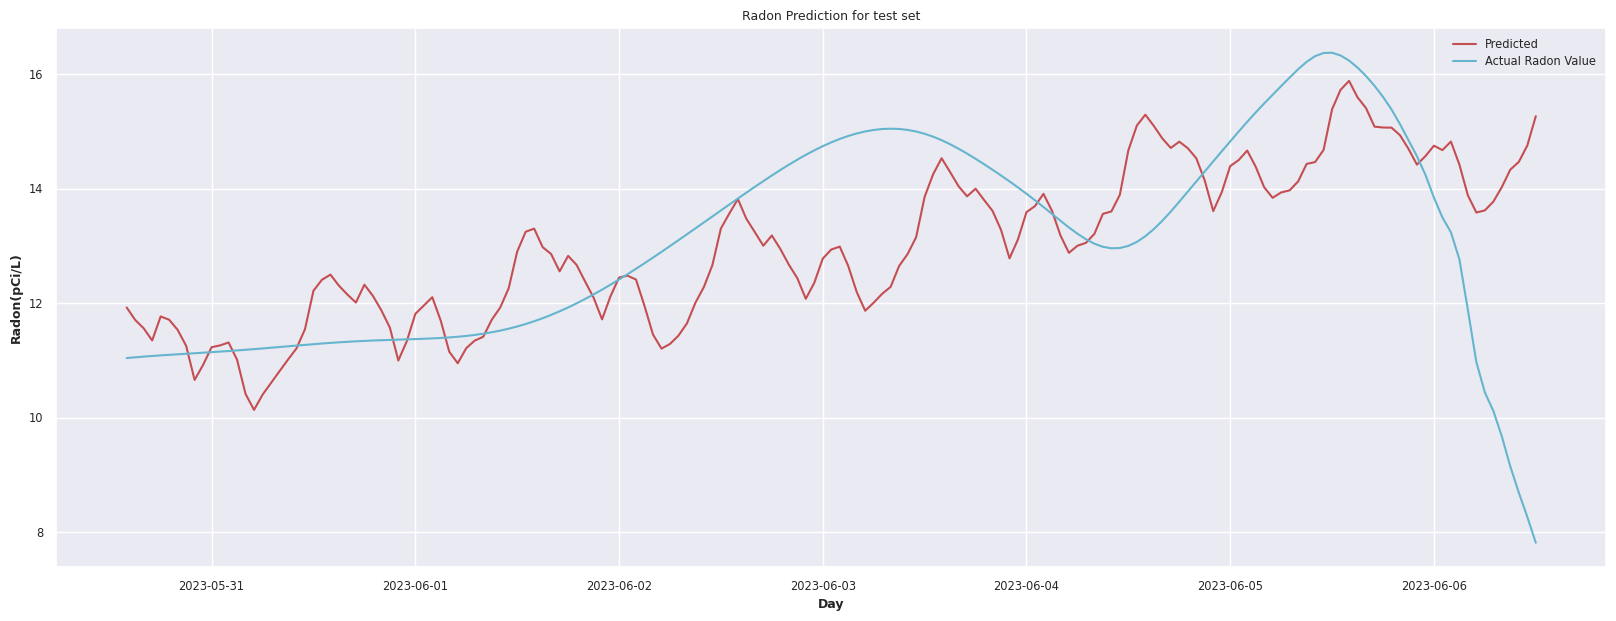

In [37]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day') 
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [38]:
df = df_radon['13'].copy()

In [39]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [40]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [41]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [42]:
weather_station = pd.read_csv('weather_data_combined.csv')

In [43]:
weather_station.drop('Date', axis=1, inplace=True)
weather_station['Simple Date'] = pd.to_datetime(weather_station['Simple Date'])
weather_station.sort_values(by='Simple Date', ascending=True, inplace=True)
weather_station['Simple Date'] = weather_station['Simple Date'].dt.floor('H')
weather_station = weather_station.resample('H', on = 'Simple Date').mean()
weather_station = weather_station.interpolate(method='linear', limit_direction='both')

In [44]:
weather_station

Outdoor h Temperature (°F)  Wind Speed (mph)  \
Simple Date                                                         
2022-05-10 00:00:00                       55.74              0.00   
2022-05-10 01:00:00                       54.79              0.00   
2022-05-10 02:00:00                       53.88              0.00   
2022-05-10 03:00:00                       52.49              0.00   
2022-05-10 04:00:00                       51.70              0.00   
...                                         ...               ...   
2023-06-07 19:00:00                       80.57              0.02   
2023-06-07 20:00:00                       77.16              0.00   
2023-06-07 21:00:00                       74.54              0.00   
2023-06-07 22:00:00                       73.51              0.06   
2023-06-07 23:00:00                       72.15              0.00   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
Simple Date                                                  
2022-05-10 00:00:00             0.00                  0.00   
2022-05-10 01:00:00             0.00                  0.00   
2022-05-10 02:00:00             0.00                  0.00   
2022-05-10 03:00:00             0.00                  0.00   
2022-05-10 04:00:00             0.00                  0.00   
...                              ...                   ...   
2023-06-07 19:00:00             0.18                  9.20   
2023-06-07 20:00:00             0.00                  9.20   
2023-06-07 21:00:00             0.00                  9.20   
2023-06-07 22:00:00             0.09                  9.20   
2023-06-07 23:00:00             0.00                  9.20   

                     Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  \
Simple Date                                                                     
2022-05-10 00:00:00              305.17                 0.00             0.00   
2022-05-10 01:00:00              302.58                 0.00             0.00   
2022-05-10 02:00:00              298.92                 0.00             0.00   
2022-05-10 03:00:00              302.92                 0.00             0.00   
2022-05-10 04:00:00              305.17                 0.00             0.00   
...                                 ...                  ...              ...   
2023-06-07 19:00:00              287.08                 0.00             0.00   
2023-06-07 20:00:00              309.83                 0.00             0.00   
2023-06-07 21:00:00              304.83                 0.00             0.00   
2023-06-07 22:00:00              307.83                 0.00             0.00   
2023-06-07 23:00:00              306.58                 0.00             0.00   

                     Daily Rain (in)  Weekly Rain (in)  Monthly Rain (in)  \
Simple Date                                                                 
2022-05-10 00:00:00             0.00              0.00               0.76   
2022-05-10 01:00:00             0.00              0.00               0.76   
2022-05-10 02:00:00             0.00              0.00               0.76   
2022-05-10 03:00:00             0.00              0.00               0.76   
2022-05-10 04:00:00             0.00              0.00               0.76   
...                              ...               ...                ...   
2023-06-07 19:00:00             0.00              0.02               0.02   
2023-06-07 20:00:00             0.00              0.02               0.02   
2023-06-07 21:00:00             0.00              0.02               0.02   
2023-06-07 22:00:00             0.00              0.02               0.02   
2023-06-07 23:00:00             0.00              0.02               0.02   

                     Yearly Rain (in)  Relative Pressure (inHg)  Humidity (%)  \
Simple Date                                                                     
2022-05-10 00:00:00             22.72                     29.13         90.67   
2022-05-10 01:00:

In [45]:
for column in weather_station.columns:
    df[column] = weather_station[column]

In [46]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.07     62.00   5.31        76.00   
2022-05-11 20:00:00        30.07     66.00   5.17        75.00   
2022-05-11 21:00:00        30.07     70.00   5.02        73.00   
2022-05-11 22:00:00        30.08     73.00   4.87        71.00   
2022-05-11 23:00:00        30.11     72.00   4.70        70.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        30.01     87.00   5.77        68.00   
2023-06-06 09:00:00        30.00     85.00   5.71        71.00   
2023-06-06 10:00:00        30.01     77.00   5.64        80.00   
2023-06-06 11:00:00        29.98     74.71   5.55        79.14   
2023-06-06 12:00:00        29.94     72.43   5.44        78.29   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [47]:
df.dropna(inplace=True)

In [48]:
df

AirPressure  Humidity  Radon  Temperature  \
SyncDate                                                         
2022-05-11 19:00:00        30.07     62.00   5.31        76.00   
2022-05-11 20:00:00        30.07     66.00   5.17        75.00   
2022-05-11 21:00:00        30.07     70.00   5.02        73.00   
2022-05-11 22:00:00        30.08     73.00   4.87        71.00   
2022-05-11 23:00:00        30.11     72.00   4.70        70.00   
...                          ...       ...    ...          ...   
2023-06-06 08:00:00        30.01     87.00   5.77        68.00   
2023-06-06 09:00:00        30.00     85.00   5.71        71.00   
2023-06-06 10:00:00        30.01     77.00   5.64        80.00   
2023-06-06 11:00:00        29.98     74.71   5.55        79.14   
2023-06-06 12:00:00        29.94     72.43   5.44        78.29   

                     Outdoor h Temperature (°F)  Wind Speed (mph)  \
SyncDate                                                            
2022-05-11 19:00:00                       77.07              0.00   
2022-05-11 20:00:00                       74.87              0.00   
2022-05-11 21:00:00                       72.88              0.00   
2022-05-11 22:00:00                       71.14              0.00   
2022-05-11 23:00:00                       69.29              0.00   
...                                         ...               ...   
2023-06-06 08:00:00                       69.51              0.29   
2023-06-06 09:00:00                       76.43              0.43   
2023-06-06 10:00:00                       81.18              0.68   
2023-06-06 11:00:00                       83.35              0.57   
2023-06-06 12:00:00                       85.52              0.76   

                     Wind Gust (mph)  Max Daily Gust (mph)  \
SyncDate                                                     
2022-05-11 19:00:00             0.09                  5.80   
2022-05-11 20:00:00             0.00                  5.80   
2022-05-11 21:00:00             0.00                  5.80   
2022-05-11 22:00:00             0.00                  5.80   
2022-05-11 23:00:00             0.00                  5.80   
...                              ...                   ...   
2023-06-06 08:00:00             1.03                  2.25   
2023-06-06 09:00:00             1.67                  4.80   
2023-06-06 10:00:00             2.05                  6.17   
2023-06-06 11:00:00             2.52                  6.90   
2023-06-06 12:00:00             2.33                  6.90   

                     Wind Direction (°)  Hourly Rain (in/hr)  ...  \
SyncDate                                                      ...   
2022-05-11 19:00:00              313.08                 0.00  ...   
2022-05-11 20:00:00              302.08                 0.00  ...   
2022-05-11 21:00:00              301.67                 0.00  ...   
2022-05-11 22:00:00              306.00                 0.00  ...   
2022-05-11 23:00:00              301.50                 0.00  ...   
...                                 ...                  ...  ...   
2023-06-06 08:00:00              307.83                 0.00  ...   
2023-06-06 09:00:00              317.17                 0.00  ...   
2023-06-06 10:00:00              308.50                 0.00  ...   
2023-06-06 11:00:00              287.25                 0.00  ...   
2023-06-06 12:00:00              303.50                 0.00  ...   

                     Weekly Rain (in)  Monthly Rain (in)  Yearly Rain (in)  \
SyncDate                                                                     
2022-05-11 19:00:00              0.00               0.76             22.72   
2022-05-11 20:00:00              0.00               0.76             22.72   
2022-05-11 21:00:00              0.00               0.76             22.72   
2022-05-11 22:00:00              0.00               0.76             22.72   
2022-05-11 23:00:00              0.00               0.76             22.72   
...          

In [49]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [50]:
df.describe()

AirPressure  Humidity   Radon  Temperature  Outdoor h Temperature (°F)  \
count      9378.00   9378.00 9378.00      9378.00                     9378.00   
mean         30.09     82.47    8.81        66.32                       62.98   
std           0.14     14.90   12.58        16.32                       14.85   
min          29.52     23.00   -1.36        16.00                        7.12   
25%          30.00     75.00    1.22        54.00                       52.55   
50%          30.09     88.00    4.38        67.00                       64.87   
75%          30.18     94.00   12.80        76.52                       73.89   
max          30.62    100.00  135.58       137.00                       98.02   

       Wind Speed (mph)  Wind Gust (mph)  Max Daily Gust (mph)  \
count           9378.00          9378.00               9378.00   
mean               0.23             0.90                  4.70   
std                0.37             1.15                  3.49   
min                0.00             0.00                  0.00   
25%                0.00             0.00                  1.48   
50%                0.03             0.37                  4.50   
75%                0.34             1.56                  6.90   
max                5.35             8.02                 20.60   

       Wind Direction (°)  Hourly Rain (in/hr)  ...  Weekly Rain (in)  \
count             9378.00              9378.00  ...           9378.00   
mean               297.71                 0.01  ...              0.54   
std                 28.84                 0.04  ...              0.85   
min                  1.33                 0.00  ...              0.00   
25%                289.00                 0.00  ...              0.00   
50%                305.58                 0.00  ...              0.09   
75%                316.08                 0.00  ...              0.72   
max                347.67                 1.23  ...              3.90   

       Monthly Rain (in)  Yearly Rain (in)  Relative Pressure (inHg)  \
count            9378.00           9378.00                   9378.00   
mean                2.88             52.63                     29.02   
std                 2.98             18.94                      0.14   
min                 0.00             22.72                     28.40   
25%                 0.76             37.85                     28.93   
50%                 2.14             47.13                     29.02   
75%                 3.72             69.48                     29.11   
max                14.68             83.42                     29.51   

       Humidity (%)  Ultra-Violet Radiation Index  Solar Radiation (W/m^2)  \
count       9378.00                       9378.00                  9378.00   
mean          76.37                          0.96                   119.51   
std           17.72                          1.79                   200.38   
min           17.17                          0.00                     0.00   
25%           65.00                          0.00                     0.00   
50%           79.92                          0.00                     2.59   
75%           91.58                          1.00                   144.45   
max           99.00                          8.00                   872.65   

       Absolute Pressure (inHg)  Avg Wind Direction (10 mins) (°)  \
count                   9378.00                           9378.00   
mean                      29.02                            308.30   
std                        0.14                             18.81   
min                       28.40                              1.42   
25%                       28.93                            302.17   
50%                       29.02                            311.08   
75%                       29.11                            318.75   
max                       29.51                            348.08   

       Avg Wind Speed (10 mins) (mph)  
count     

In [51]:
for column in df.columns:
    df[column] = df[column].astype('float32')
    if column == 'Radon':
        continue
    else:
        for i in range(1,40):
            df[column+'_lag_'+str(i)] = df[column].shift(i)

In [52]:
df.fillna(0, inplace=True)

In [53]:
# check correlations of features with price
df_corr = df.corr(method="spearman")
print(df_corr.shape)
print("correlation with Radon:")
df_corrP = pd.DataFrame(df_corr["Radon"].sort_values(ascending=False))
df_corrP

(841, 841)
correlation with Radon:


Radon
Radon                     1.00
Temperature_lag_17        0.54
Temperature_lag_18        0.54
Temperature_lag_16        0.54
Temperature               0.54
...                        ...
Yearly Rain (in)_lag_35  -0.64
Yearly Rain (in)_lag_36  -0.64
Yearly Rain (in)_lag_37  -0.64
Yearly Rain (in)_lag_38  -0.64
Yearly Rain (in)_lag_39  -0.64

[841 rows x 1 columns]

In [54]:
# highest absolute correlations with Radon
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[(df_corrP["Radon"]) >= 0.54103]
df_corrH

Radon
Radon                1.00
Temperature_lag_17   0.54

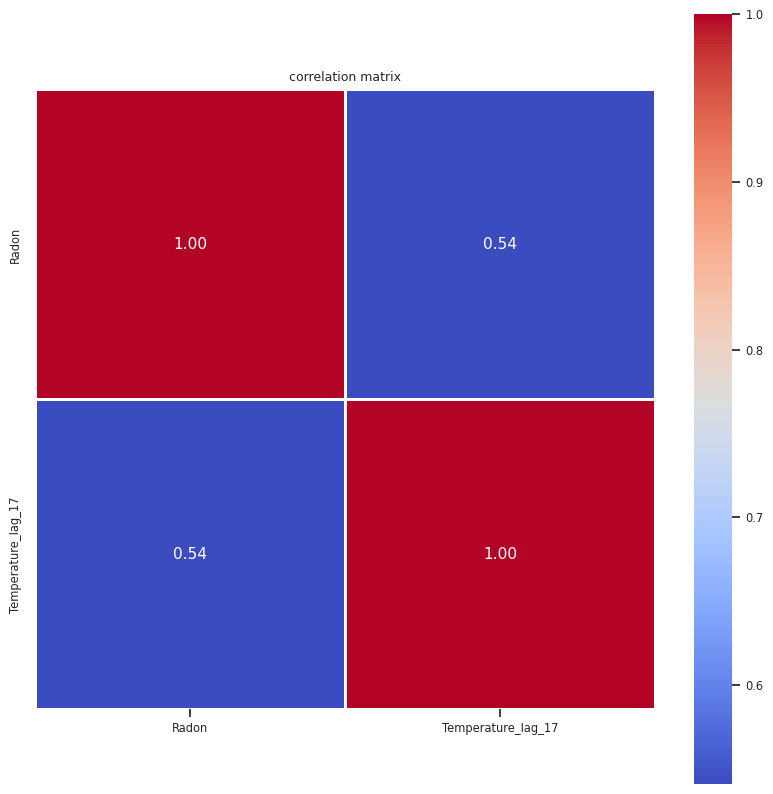

In [55]:
# helper method: correlation matrix as heatmap
def corr_heatmap(df):
    idx = df.corr().sort_values("Radon", ascending=False).index
    df_sorted = df.loc[:, idx]  # sort dataframe columns by their correlation 

    #plt.figure(figsize = (15,15))
    sns.set(font_scale=0.75)
    ax = sns.heatmap(df_sorted.corr(method='spearman').round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
    ax.xaxis.tick_bottom()
    plt.title("correlation matrix")
    plt.show()



# visualize correlations with price     

df4 = df[df_corrH.index]   # keep the components with at least modest correlations

plt.figure(figsize = (10,10))
corr_heatmap(df4)

In [56]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9378 entries, 2022-05-11 19:00:00 to 2023-06-06 12:00:00
Freq: H
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Radon               9378 non-null   float32
 1   Temperature_lag_17  9378 non-null   float32
dtypes: float32(2)
memory usage: 146.5 KB


In [57]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [58]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "Radon"]
df_covF = df_covF.loc[:, df_covF.columns != 'Outdoor h Temperature (°F)']
ts_covF = TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq="H")

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['Temperature_lag_17'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [59]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [60]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [61]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(9378, 1, 1)

In [62]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [63]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-06-06 12:00:00   0.05

In [64]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(split_point=9210)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  
# covF_t = ts_covF
# covF_ttrain = covF_train
# covF_ttest = covF_test
# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component            Temperature_lag_17
SyncDate                               
2022-05-11 19:00:00                0.00
2023-06-06 12:00:00                0.55

In [65]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component            Radon
SyncDate                  
2022-05-11 19:00:00   0.05
2023-05-30 13:00:00   0.03

In [66]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nbeats_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"past": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
    if model_args['layer_widths'] == 'a':
        layer_widths = [64,64]
    elif model_args['layer_widths'] == 'b':
        layer_widths = [128,128]
    elif model_args['layer_widths'] == 'c':
        layer_widths = [256,256]
    elif model_args['layer_widths'] == 'd':
        layer_widths = [64,128]
    elif model_args['layer_widths'] == 'e':
        layer_widths = [128,256]
    elif model_args['layer_widths'] == 'f':
        layer_widths = [256,512]
    elif model_args['layer_widths'] == 'g':
        layer_widths = [64, 256]

    model = NBEATSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NBEATS",
        generic_architecture = True,
        num_stacks=2,
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        layer_widths = layer_widths,
        expansion_coefficient_dim = model_args['expansion_coefficient_dim'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                past_covariates=covF_t,
                val_series=val_series,
                val_past_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                past_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [67]:
def build_fit_nbeats_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    encoders={"cyclic": {"past": ["hour"]},
             'transformer':Scaler()} if model_args['include_hour'] else None
    
    if model_args['layer_widths'] == 'a':
        layer_widths = [64,64]
    elif model_args['layer_widths'] == 'b':
        layer_widths = [128,128]
    elif model_args['layer_widths'] == 'c':
        layer_widths = [256,256]
    elif model_args['layer_widths'] == 'd':
        layer_widths = [64,128]
    elif model_args['layer_widths'] == 'e':
        layer_widths = [128,256]
    elif model_args['layer_widths'] == 'f':
        layer_widths = [256,512]
    elif model_args['layer_widths'] == 'g':
        layer_widths = [64, 256]

    model = NBEATSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NBEATS",
        generic_architecture = True,
        num_stacks=2,
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        layer_widths =layer_widths,
        expansion_coefficient_dim = model_args['expansion_coefficient_dim'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        add_encoders=encoders,
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                past_covariates=covF_t,
                val_series=val_series,
                val_past_covariates=covF_t,)
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [68]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,30),
    "out_len":tune.randint(1,4),
    "batch_size":tune.choice([32,64,128,256]),
    "num_blocks": tune.randint(1,10),
    "num_layers":tune.randint(1,5),
    "layer_widths":tune.choice(['a','b','c','d','e','f','g']),
    "expansion_coefficient_dim":tune.randint(10, 50),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU','Sigmoid']),
    "lr":tune.loguniform(1e-5,1e-1),
    "include_hour":tune.choice([True,False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nbeats_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="nbeats_tune_cov",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 17:23:10 (running for 00:00:00.15)
Memory usage on this node: 13.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 1/100 (1 RUNNING)
+---------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-----------+----------------+
| Trial name                      | status   | loc                  |   in_len |   out_len |   batch_size |   num_blocks |   num_layers | layer_widths   |   expansion_coefficien |   dropout | activation   |        lr | include_hour   |
|                                 |          |                      |        

(build_fit_nbeats_model pid=1473773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1473773)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1473773)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473773) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473773) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473773) TPU a

== Status ==
Current time: 2023-07-08 17:23:20 (running for 00:00:09.50)
Memory usage on this node: 19.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+---------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------------+----------------+
| Trial name                      | status   | loc                  |   in_len |   out_len |   batch_size |   num_blocks |   num_layers | layer_widths   |   expansion_coefficien |   dropout | activation   |          lr | include_hour   |
|                                 |          |

(build_fit_nbeats_model pid=1474007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1474007)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1474007)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473997) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473997) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473997) TPU a

(build_fit_nbeats_model pid=1474059) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1474059) 
(build_fit_nbeats_model pid=1474059)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1474059) ---------------------------------------------------
(build_fit_nbeats_model pid=1474059) 0 | criterion     | SmapeLoss        | 0     
(build_fit_nbeats_model pid=1474059) 1 | train_metrics | MetricCollection | 0     
(build_fit_nbeats_model pid=1474059) 2 | val_metrics   | MetricCollection | 0     
(build_fit_nbeats_model pid=1474059) 3 | stacks        | ModuleList       | 9.1 M 
(build_fit_nbeats_model pid=1474059) ---------------------------------------------------
(build_fit_nbeats_model pid=1474059) 9.0 M     Trainable params
(build_fit_nbeats_model pid=1474059) 21.4 K    Non-trainable params
(build_fit_nbeats_model pid=1474059) 9.1 M     Total params
(build_fit_nbeats_model pid=1474059) 36.252    Total estimated model params size (MB)
(build_fit_n

(build_fit_nbeats_model pid=1474059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1474059)   rank_zero_warn(
(build_fit_nbeats_model pid=1474059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1474059)   rank_zero_warn(
(build_fit_nbeats_model pid=1474007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by do

(build_fit_nbeats_model pid=1473773) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


(build_fit_nbeats_model pid=1473773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1473773)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1473773)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473773) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473773) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473773) TPU a

== Status ==
Current time: 2023-07-08 17:23:29 (running for 00:00:19.11)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d3d711d7 with q_smape=200.0 and parameters={'in_len': 28, 'out_len': 3, 'batch_size': 256, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 25, 'dropout': 0.19275959073940527, 'activation': 'LeakyReLU', 'lr': 0.072795683859, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 10/100 (1 PENDING, 8 RUNNING, 1 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+------------

(build_fit_nbeats_model pid=1475613) Auto select gpus: [0]
(build_fit_nbeats_model pid=1475613) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1475613) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1475613) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1475613) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1475613) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1475613) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1475613) 
(build_fit_nbeats_model pid=1475613)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1475613) ---------------

(build_fit_nbeats_model pid=1474010) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1474010) Auto select gpus: [0]
(build_fit_nbeats_model pid=1474010) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1474010) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1474010) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1474010) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1474010) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1474010) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1474010) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nbeat

(build_fit_nbeats_model pid=1474010) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


(build_fit_nbeats_model pid=1475853) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1475853)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1475853) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1475853)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:23:39 (running for 00:00:29.11)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d3d711d7 with q_smape=200.0 and parameters={'in_len': 28, 'out_len': 3, 'batch_size': 256, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 25, 'dropout': 0.19275959073940527, 'activation': 'LeakyReLU', 'lr': 0.072795683859, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+------------

(build_fit_nbeats_model pid=1475853) Auto select gpus: [0]
(build_fit_nbeats_model pid=1475853) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1475853) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1475853) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1475853) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1475853) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1475853) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1475853) 
(build_fit_nbeats_model pid=1475853)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1475853) ---------------

== Status ==
Current time: 2023-07-08 17:23:44 (running for 00:00:34.12)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d3d711d7 with q_smape=200.0 and parameters={'in_len': 28, 'out_len': 3, 'batch_size': 256, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 25, 'dropout': 0.19275959073940527, 'activation': 'LeakyReLU', 'lr': 0.072795683859, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+------------

(build_fit_nbeats_model pid=1475853) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1475853)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1475853) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1475853)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1475853) Auto select gpus: [0]
(build_fit_nbeats_model pid=1475853) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1475853) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]
== Status ==
Current time: 2023-07-08 17:23:50 (running for 00:00:40.10)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: d3d711d7 with q_smape=200.0 and parameters={'in_len': 28, 'out_len': 3, 'batch_size': 256, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 25, 'dropout': 0.19275959073940527, 'activation': 'LeakyReLU', 'lr': 0.072795683859, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 11/100 (8 RUNNING, 3 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+------

(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1476095)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1476095)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1473997) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473997) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473997) TPU a

(build_fit_nbeats_model pid=1473997) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1476095) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476095) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476095) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1476095) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1476095) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1476095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1476095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1476095) 
(build_fit_nbeats_model pid=1476095)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1476095) ---------------

(build_fit_nbeats_model pid=1473997) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1476095)   rank_zero_warn(
(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1476095)   rank_zero_warn(
(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:23:56 (running for 00:00:45.86)
Memory usage on this node: 28.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 98c00a1a with q_smape=82.72897601127625 and parameters={'in_len': 21, 'out_len': 3, 'batch_size': 128, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 37, 'dropout': 0.43256538661516697, 'activation': 'Tanh', 'lr': 0.001549532519184312, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1476329) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1476329)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476329) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1476329)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1475613) Auto select gpus: [0]
(build_fit_nbeats_model pid=1475613) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1475613) TPU a

(build_fit_nbeats_model pid=1475613) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1476329) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476329) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476329) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1476329) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1476329) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1476329) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1476329) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1476329) 
(build_fit_nbeats_model pid=1476329)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1476329) ---------------

(build_fit_nbeats_model pid=1475613) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


(build_fit_nbeats_model pid=1476329) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1476329)   rank_zero_warn(
(build_fit_nbeats_model pid=1476329) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1476329)   rank_zero_warn(
(build_fit_nbeats_model pid=1476329) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:24:01 (running for 00:00:51.05)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 98c00a1a with q_smape=82.72897601127625 and parameters={'in_len': 21, 'out_len': 3, 'batch_size': 128, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 37, 'dropout': 0.43256538661516697, 'activation': 'Tanh', 'lr': 0.001549532519184312, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 14/100 (1 PENDING, 8 RUNNING, 5 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1476568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1476568)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1476568)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476568) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476568) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476568) TPU a

== Status ==
Current time: 2023-07-08 17:24:10 (running for 00:01:00.13)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 98c00a1a with q_smape=82.72897601127625 and parameters={'in_len': 21, 'out_len': 3, 'batch_size': 128, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 37, 'dropout': 0.43256538661516697, 'activation': 'Tanh', 'lr': 0.001549532519184312, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1476807) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476807) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476807) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1476807) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1476807) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1476807) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1476807) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1476807) 
(build_fit_nbeats_model pid=1476807)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1476807) ---------------

== Status ==
Current time: 2023-07-08 17:24:15 (running for 00:01:05.14)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 98c00a1a with q_smape=82.72897601127625 and parameters={'in_len': 21, 'out_len': 3, 'batch_size': 128, 'num_blocks': 2, 'num_layers': 4, 'layer_widths': 'c', 'expansion_coefficient_dim': 37, 'dropout': 0.43256538661516697, 'activation': 'Tanh', 'lr': 0.001549532519184312, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 15/100 (1 PENDING, 8 RUNNING, 6 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1474002) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1474002)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474002) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1474002)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474002) Auto select gpus: [0]
(build_fit_nbeats_model pid=1474002) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1474002) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


(build_fit_nbeats_model pid=1474059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1474059)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474059) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1474059)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474059) Auto select gpus: [0]
(build_fit_nbeats_model pid=1474059) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1474059) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1477094)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1477094)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

(build_fit_nbeats_model pid=1476095) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1476095) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nbeats_model pid=1476095)   X /= self.scale_
(build_fit_nbeats_model pid=1476095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nbeats_model pid=1476095)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nbeats_model pid=1477094) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477094) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477094) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1477094) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1477094) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1477094) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To proper

== Status ==
Current time: 2023-07-08 17:24:23 (running for 00:01:12.37)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 17/100 (1 PENDING, 8 RUNNING, 8 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+------

(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1477094)   rank_zero_warn(
(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1477094)   rank_zero_warn(
(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:24:29 (running for 00:01:19.13)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+------

(build_fit_nbeats_model pid=1477569) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477569) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477569) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1477569) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1477569) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1477569) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1477569) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1477569) 
(build_fit_nbeats_model pid=1477569)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1477569) ---------------

== Status ==
Current time: 2023-07-08 17:24:34 (running for 00:01:24.13)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 18/100 (1 PENDING, 8 RUNNING, 9 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+------

(build_fit_nbeats_model pid=1473999) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1473999) Auto select gpus: [0]
(build_fit_nbeats_model pid=1473999) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1473999) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1473999) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1473999) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1473999) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1473999) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1477094)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477094) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1477094)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477094) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477094) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477094) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


(build_fit_nbeats_model pid=1477869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1477869)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1477869)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477871) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:24:48 (running for 00:01:38.14)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1477869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1477869)   rank_zero_warn(
(build_fit_nbeats_model pid=1477869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1477869)   rank_zero_warn(
(build_fit_nbeats_model pid=1477871) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing 

== Status ==
Current time: 2023-07-08 17:24:53 (running for 00:01:43.15)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 21/100 (1 PENDING, 8 RUNNING, 12 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1476807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1476807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1476807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1476807) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476807) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476807) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1477871) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1477871)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477871) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1477871)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1477871) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477871) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477871) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]
== Status ==
Current time: 2023-07-08 17:25:00 (running for 00:01:49.70)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 22/100 (1 PENDING, 8 RUNNING, 13 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+------

(build_fit_nbeats_model pid=1478573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1478573)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1478573)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478573) Auto select gpus: [0]
(build_fit_nbeats_model pid=1478573) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1478573) TPU a

(build_fit_nbeats_model pid=1477258) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1477258) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477258) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477258) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1477258) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1477258) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1477258) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1477258) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
== Status ==
Current time: 2023-07-08 17:25:05 (running for 00:01:54.96)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 23/100 (1 PENDING, 8 RUNNING, 14 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+------

(build_fit_nbeats_model pid=1478807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1478807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1478807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478807) Auto select gpus: [0]
(build_fit_nbeats_model pid=1478807) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1478807) TPU a

== Status ==
Current time: 2023-07-08 17:25:12 (running for 00:02:02.15)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1479044) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479044) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479044) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1479044) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1479044) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1479044) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1479044) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1479044) 
(build_fit_nbeats_model pid=1479044)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1479044) ---------------

== Status ==
Current time: 2023-07-08 17:25:17 (running for 00:02:07.16)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 24/100 (1 PENDING, 8 RUNNING, 15 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1476329) Auto select gpus: [0]
(build_fit_nbeats_model pid=1476329) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1476329) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1476329) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1476329) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1476329) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1476329) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1476329) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


(build_fit_nbeats_model pid=1478807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1478807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478807) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1478807)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478807) Auto select gpus: [0]
(build_fit_nbeats_model pid=1478807) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1478807) TPU a

(build_fit_nbeats_model pid=1478807) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1478807) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


(build_fit_nbeats_model pid=1477869) Auto select gpus: [0]
(build_fit_nbeats_model pid=1477869) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1477869) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1477869) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1477869) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1477869) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1477869) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 17:25:23 (running for 00:02:13.12)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 24/100 (8 RUNNING, 16 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+----------

(build_fit_nbeats_model pid=1479292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479292)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479292)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479292) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479292) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479292) TPU a

== Status ==
Current time: 2023-07-08 17:25:28 (running for 00:02:18.15)
Memory usage on this node: 25.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 26/100 (8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+----

(build_fit_nbeats_model pid=1479534) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479534)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479534) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479534)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479536) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:25:38 (running for 00:02:27.75)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

== Status ==
Current time: 2023-07-08 17:25:48 (running for 00:02:37.77)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

== Status ==
Current time: 2023-07-08 17:25:58 (running for 00:02:47.79)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 27/100 (1 PENDING, 8 RUNNING, 18 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1479292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479292)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479292) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479292)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479292) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479292) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479292) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


(build_fit_nbeats_model pid=1479044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479044) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479044)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479044) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479044) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479044) TPU a

(build_fit_nbeats_model pid=1476568) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1480022) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480022)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480022) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480022)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:26:05 (running for 00:02:55.19)
Memory usage on this node: 28.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 29/100 (1 PENDING, 8 RUNNING, 20 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1480024) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480024) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480024) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1480024) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1480024) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1480024) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1480022) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480022) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480022) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1480022) IP

== Status ==
Current time: 2023-07-08 17:26:11 (running for 00:03:01.16)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1480485) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480485) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480485) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1480485) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1480485) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1480485) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1480485) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1480485) 
(build_fit_nbeats_model pid=1480485)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1480485) ---------------

== Status ==
Current time: 2023-07-08 17:26:16 (running for 00:03:06.17)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 30/100 (1 PENDING, 8 RUNNING, 21 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1478573) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1478573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1478573)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478573) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1478573)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478573) Auto select gpus: [0]
(build_fit_nbeats_model pid=1478573) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1478573) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1479536) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479536)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479536) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479536)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479536) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479536) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479536) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
== Status ==
Current time: 2023-07-08 17:26:28 (running for 00:03:17.70)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 31/100 (1 PENDING, 8 RUNNING, 22 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+------

(build_fit_nbeats_model pid=1480732) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480732)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480732) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480732)   rank_zero_deprecation(


(build_fit_nbeats_model pid=1479534) 
Predicting: 0it [00:00, ?it/s]
(build_fit_nbeats_model pid=1479534) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1479534) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1479534)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479534) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1479534)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1479534) Auto select gpus: [0]
(build_fit_nbeats_model pid=1479534) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1479534) TPU a

(build_fit_nbeats_model pid=1479534) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


(build_fit_nbeats_model pid=1480732) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480732) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480732) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1480732) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1480732) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1480732) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1480732) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1480732) 
(build_fit_nbeats_model pid=1480732)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1480732) ---------------

== Status ==
Current time: 2023-07-08 17:26:36 (running for 00:03:26.20)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1480975) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480975) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480975) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1480975) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1480975) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1480975) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1480975) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1480975) 
(build_fit_nbeats_model pid=1480975)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1480975) ---------------

== Status ==
Current time: 2023-07-08 17:26:41 (running for 00:03:31.21)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 33/100 (1 PENDING, 8 RUNNING, 24 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1480024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480024)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480024) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480024)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480024) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480024) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480024) TPU a

== Status ==
Current time: 2023-07-08 17:26:50 (running for 00:03:40.16)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 34/100 (1 PENDING, 8 RUNNING, 25 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1481453) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481453) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481453) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1481453) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1481453) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1481453) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1481453) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1481453) 
(build_fit_nbeats_model pid=1481453)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1481453) ---------------

(build_fit_nbeats_model pid=1480485) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1480485) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480485)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480485) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480485)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480485) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480485) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480485) TPU a

(build_fit_nbeats_model pid=1480485) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


(build_fit_nbeats_model pid=1481692) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1481692)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481692) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1481692)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:27:00 (running for 00:03:50.16)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 35/100 (1 PENDING, 8 RUNNING, 26 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1481692) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481692) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481692) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1481692) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1481692) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1481692) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1481692) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1481692) 
(build_fit_nbeats_model pid=1481692)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1481692) ---------------

(build_fit_nbeats_model pid=1478182) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1478182) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


(build_fit_nbeats_model pid=1478182) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1478182)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478182) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1478182)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1478182) Auto select gpus: [0]
(build_fit_nbeats_model pid=1478182) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1478182) TPU a

(build_fit_nbeats_model pid=1480022) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1480022) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480022)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480022) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480022)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480022) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480022) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480022) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
== Status ==
Current time: 2023-07-08 17:27:09 (running for 00:03:58.50)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 36/100 (1 PENDING, 8 RUNNING, 27 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+------

(build_fit_nbeats_model pid=1481933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1481933)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1481933)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481933) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481933) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481933) TPU a

(build_fit_nbeats_model pid=1480975) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


(build_fit_nbeats_model pid=1480975) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480975)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480975) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480975)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480975) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.

== Status ==
Current time: 2023-07-08 17:27:17 (running for 00:04:07.17)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 38/100 (1 PENDING, 8 RUNNING, 29 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1482333) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482333) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482333) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1482333) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1482333) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1482333) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1482333) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1482333) 
(build_fit_nbeats_model pid=1482333)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1482333) ---------------

(build_fit_nbeats_model pid=1480732) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1480732) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


(build_fit_nbeats_model pid=1480732) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480732)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480732) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480732)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480732) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480732) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480732) TPU a

== Status ==
Current time: 2023-07-08 17:27:23 (running for 00:04:13.16)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1482643) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482643) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482643) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1482643) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1482643) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1482643) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1482643) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1482643) 
(build_fit_nbeats_model pid=1482643)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1482643) ---------------

== Status ==
Current time: 2023-07-08 17:27:28 (running for 00:04:18.18)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

== Status ==
Current time: 2023-07-08 17:27:38 (running for 00:04:28.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 39/100 (1 PENDING, 8 RUNNING, 30 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1480977) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1480977) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


(build_fit_nbeats_model pid=1480977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1480977)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1480977)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1480977) Auto select gpus: [0]
(build_fit_nbeats_model pid=1480977) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1480977) TPU a

== Status ==
Current time: 2023-07-08 17:27:51 (running for 00:04:41.17)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 40/100 (1 PENDING, 8 RUNNING, 31 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1481453) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1481453)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481453) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1481453)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481453) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481453) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481453) TPU a

(build_fit_nbeats_model pid=1481453) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


(build_fit_nbeats_model pid=1482894) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482894) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482894) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1482894) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1482894) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1482894) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1482894) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1482894) 
(build_fit_nbeats_model pid=1482894)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1482894) ---------------

== Status ==
Current time: 2023-07-08 17:27:57 (running for 00:04:47.17)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1483130) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483130) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483130) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1483130) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1483130) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1483130) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1483130) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1483130) 
(build_fit_nbeats_model pid=1483130)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1483130) ---------------

== Status ==
Current time: 2023-07-08 17:28:02 (running for 00:04:52.18)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 41/100 (1 PENDING, 8 RUNNING, 32 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1482168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1482168)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482168) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1482168)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482168) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482168) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482168) TPU a

== Status ==
Current time: 2023-07-08 17:28:11 (running for 00:05:01.17)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 2605cd21 with q_smape=46.72773480415344 and parameters={'in_len': 20, 'out_len': 2, 'batch_size': 64, 'num_blocks': 6, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 29, 'dropout': 0.23928741820945143, 'activation': 'LeakyReLU', 'lr': 0.0005125838289136211, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 42/100 (1 PENDING, 8 RUNNING, 33 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----

(build_fit_nbeats_model pid=1483374) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483374) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483374) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1483374) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1483374) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1483374) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1483374) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1483374) 
(build_fit_nbeats_model pid=1483374)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1483374) ---------------

(build_fit_nbeats_model pid=1481692) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1481692) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1481692)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481692) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1481692)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481692) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481692) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481692) TPU a

(build_fit_nbeats_model pid=1481692) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


(build_fit_nbeats_model pid=1483615) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483615)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483615) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483615)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:28:21 (running for 00:05:11.17)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 43/100 (1 PENDING, 8 RUNNING, 34 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1483615) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483615) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483615) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1483615) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1483615) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1483615) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1483615) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1483615) 
(build_fit_nbeats_model pid=1483615)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1483615) ---------------

(build_fit_nbeats_model pid=1482333) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1482333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1482333)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482333) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1482333)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482333) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482333) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482333) TPU a

(build_fit_nbeats_model pid=1482333) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


(build_fit_nbeats_model pid=1483855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483855)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483855)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:28:31 (running for 00:05:21.18)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1483855) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483855) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483855) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1483855) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1483855) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1483855) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1483855) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1483855) 
(build_fit_nbeats_model pid=1483855)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1483855) ---------------

== Status ==
Current time: 2023-07-08 17:28:36 (running for 00:05:26.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

== Status ==
Current time: 2023-07-08 17:28:46 (running for 00:05:36.22)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

== Status ==
Current time: 2023-07-08 17:28:56 (running for 00:05:46.25)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 44/100 (1 PENDING, 8 RUNNING, 35 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------

(build_fit_nbeats_model pid=1482643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1482643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1482643)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482643) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482643) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482643) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]
== Status ==
Current time: 2023-07-08 17:29:02 (running for 00:05:52.15)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 1b806eac with q_smape=34.43179130554199 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 1, 'layer_widths': 'g', 'expansion_coefficient_dim': 16, 'dropout': 0.4976072439486289, 'activation': 'ReLU', 'lr': 0.0005102065420772691, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 44/100 (8 RUNNING, 36 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------

(build_fit_nbeats_model pid=1484105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484105) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484105) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484105) TPU a

(build_fit_nbeats_model pid=1481933) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1481933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1481933)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481933) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1481933)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1481933) Auto select gpus: [0]
(build_fit_nbeats_model pid=1481933) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1481933) TPU a

== Status ==
Current time: 2023-07-08 17:29:09 (running for 00:05:58.79)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fff2bc4b with q_smape=34.19337272644043 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 2, 'layer_widths': 'e', 'expansion_coefficient_dim': 16, 'dropout': 0.275800832339424, 'activation': 'ReLU', 'lr': 0.0004899965601800401, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 45/100 (1 PENDING, 8 RUNNING, 36 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+

(build_fit_nbeats_model pid=1484387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484387)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484387)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:29:14 (running for 00:06:04.19)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: fff2bc4b with q_smape=34.19337272644043 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 32, 'num_blocks': 4, 'num_layers': 2, 'layer_widths': 'e', 'expansion_coefficient_dim': 16, 'dropout': 0.275800832339424, 'activation': 'ReLU', 'lr': 0.0004899965601800401, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 46/100 (1 PENDING, 8 RUNNING, 37 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+

(build_fit_nbeats_model pid=1483130) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483130)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483130) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483130)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483130) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483130) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483130) TPU a

== Status ==
Current time: 2023-07-08 17:29:20 (running for 00:06:10.19)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1484623) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484623) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484623) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1484623) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1484623) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1484623) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1484623) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1484623) 
(build_fit_nbeats_model pid=1484623)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1484623) ---------------

== Status ==
Current time: 2023-07-08 17:29:25 (running for 00:06:15.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 47/100 (1 PENDING, 8 RUNNING, 38 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1483374) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1483374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483374)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483374)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483374) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483374) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483374) TPU a

(build_fit_nbeats_model pid=1483374) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


(build_fit_nbeats_model pid=1484911) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484911)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484911) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484911)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:29:38 (running for 00:06:28.18)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1484911) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484911) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484911) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1484911) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1484911) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1484911) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1484911) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1484911) 
(build_fit_nbeats_model pid=1484911)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1484911) ---------------

== Status ==
Current time: 2023-07-08 17:29:43 (running for 00:06:33.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 48/100 (1 PENDING, 8 RUNNING, 39 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1484387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484387)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484387)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484387) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484387) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484387) TPU a

(build_fit_nbeats_model pid=1484387) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


(build_fit_nbeats_model pid=1485153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1485153)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1485153) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1485153)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:29:52 (running for 00:06:42.18)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1485153) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485153) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485153) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485153) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485153) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1485153) 
(build_fit_nbeats_model pid=1485153)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1485153) ---------------

== Status ==
Current time: 2023-07-08 17:29:57 (running for 00:06:47.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:30:07 (running for 00:06:57.22)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 49/100 (1 PENDING, 8 RUNNING, 40 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1483615) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483615)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483615) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483615)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483615) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483615) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483615) TPU a

(build_fit_nbeats_model pid=1483615) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


(build_fit_nbeats_model pid=1485402) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1485402)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1485402) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1485402)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:30:18 (running for 00:07:08.19)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1485402) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485402) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485402) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485402) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485402) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485402) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485402) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1485402) 
(build_fit_nbeats_model pid=1485402)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1485402) ---------------

== Status ==
Current time: 2023-07-08 17:30:23 (running for 00:07:13.20)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 50/100 (1 PENDING, 8 RUNNING, 41 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1483855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1483855)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1483855)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1483855) Auto select gpus: [0]
(build_fit_nbeats_model pid=1483855) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1483855) TPU a

(build_fit_nbeats_model pid=1483855) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]
(build_fit_nbeats_model pid=1484623) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1484623) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484623)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484623) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484623)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484623) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484623) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484623) TPU a

(build_fit_nbeats_model pid=1484623) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


(build_fit_nbeats_model pid=1485651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1485651)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1485651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1485651)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1485653) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:30:30 (running for 00:07:20.24)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 52/100 (1 PENDING, 8 RUNNING, 43 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1485651) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485651) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485651) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485651) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485651) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485651) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485651) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1485651) 
(build_fit_nbeats_model pid=1485651)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1485651) ---------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


(build_fit_nbeats_model pid=1486118) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1486118)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486118) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1486118)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:30:38 (running for 00:07:28.19)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 53/100 (1 PENDING, 8 RUNNING, 44 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1486118) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486118) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486118) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1486118) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1486118) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1486118) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1486118) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1486118) 
(build_fit_nbeats_model pid=1486118)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1486118) ---------------

(build_fit_nbeats_model pid=1485153) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1485153) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485153) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485153) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485153) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485153) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485153) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485153) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1485153) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


(build_fit_nbeats_model pid=1484105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1484105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484105) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1484105)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1484105) Auto select gpus: [0]
(build_fit_nbeats_model pid=1484105) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1484105) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
== Status ==
Current time: 2023-07-08 17:30:44 (running for 00:07:33.44)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 54/100 (1 PENDING, 8 RUNNING, 45 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1486359) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1486359)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486359) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1486359)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486359) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486359) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486359) TPU a

(build_fit_nbeats_model pid=1482894) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1482894) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


(build_fit_nbeats_model pid=1482894) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1482894)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482894) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1482894)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1482894) Auto select gpus: [0]
(build_fit_nbeats_model pid=1482894) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1482894) TPU a

== Status ==
Current time: 2023-07-08 17:30:53 (running for 00:07:42.36)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 55/100 (1 PENDING, 8 RUNNING, 46 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1486594) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1486594)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486594) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1486594)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486594) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486594) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486594) TPU a

== Status ==
Current time: 2023-07-08 17:30:58 (running for 00:07:48.19)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1486834) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486834) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486834) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1486834) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1486834) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1486834) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1486834) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1486834) 
(build_fit_nbeats_model pid=1486834)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1486834) ---------------

== Status ==
Current time: 2023-07-08 17:31:03 (running for 00:07:53.21)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:31:13 (running for 00:08:03.23)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 56/100 (1 PENDING, 8 RUNNING, 47 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1485402) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485402) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485402) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485402) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485402) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485402) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485402) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1485653) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485653) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485653) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485653) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485653) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485653) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485653) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1485653) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


(build_fit_nbeats_model pid=1487086) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487086)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487086) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487086)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487086) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487086) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487086) TPU a

== Status ==
Current time: 2023-07-08 17:31:23 (running for 00:08:13.20)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1487249) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487249) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487249) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1487249) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1487249) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1487249) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1487249) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1487249) 
(build_fit_nbeats_model pid=1487249)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1487249) ---------------

== Status ==
Current time: 2023-07-08 17:31:28 (running for 00:08:18.22)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:31:38 (running for 00:08:28.24)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:31:49 (running for 00:08:38.27)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:31:59 (running for 00:08:48.29)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:32:09 (running for 00:08:58.31)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:32:19 (running for 00:09:08.33)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:32:29 (running for 00:09:18.35)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:32:39 (running for 00:09:28.38)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 58/100 (1 PENDING, 8 RUNNING, 49 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1487086) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487086) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487086) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1487086) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1487086) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1487086) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1487086) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1487086) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


(build_fit_nbeats_model pid=1487591) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487591)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487591) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487591)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:32:47 (running for 00:09:37.21)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1487591) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487591) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487591) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1487591) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1487591) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1487591) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1487591) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1487591) 
(build_fit_nbeats_model pid=1487591)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1487591) ---------------

== Status ==
Current time: 2023-07-08 17:32:52 (running for 00:09:42.24)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 59/100 (1 PENDING, 8 RUNNING, 50 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1487249) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487249)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487249) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487249)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487249) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487249) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487249) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1486359) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486359) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486359) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1486359) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1486359) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1486359) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1486359) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
== Status ==
Current time: 2023-07-08 17:32:58 (running for 00:09:47.81)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 60/100 (1 PENDING, 8 RUNNING, 51 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1487833) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487833)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487833) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487833)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487833) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487833) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487833) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]
== Status ==
Current time: 2023-07-08 17:33:05 (running for 00:09:55.01)
Memory usage on this node: 29.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 61/100 (1 PENDING, 8 RUNNING, 52 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1488067) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1488067)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488067) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1488067)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488067) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488067) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488067) TPU a

== Status ==
Current time: 2023-07-08 17:33:11 (running for 00:10:01.22)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1488306) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488306) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488306) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488306) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488306) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488306) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488306) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1488306) 
(build_fit_nbeats_model pid=1488306)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1488306) ---------------

== Status ==
Current time: 2023-07-08 17:33:16 (running for 00:10:06.23)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:33:27 (running for 00:10:16.25)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:33:37 (running for 00:10:26.28)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 62/100 (1 PENDING, 8 RUNNING, 53 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1488306) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488306) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488306) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488306) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488306) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488306) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488306) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1488306) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


(build_fit_nbeats_model pid=1488558) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1488558)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488558) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1488558)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:33:43 (running for 00:10:33.22)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 63/100 (1 PENDING, 8 RUNNING, 54 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1488558) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488558) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488558) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488558) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488558) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488558) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488558) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1488558) 
(build_fit_nbeats_model pid=1488558)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1488558) ---------------

(build_fit_nbeats_model pid=1486594) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1486594) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1486594)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486594) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1486594)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486594) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486594) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486594) TPU a

(build_fit_nbeats_model pid=1486594) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


(build_fit_nbeats_model pid=1474007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1474007)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474007) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1474007)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1474007) Auto select gpus: [0]
(build_fit_nbeats_model pid=1474007) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1474007) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


(build_fit_nbeats_model pid=1485651) Auto select gpus: [0]
(build_fit_nbeats_model pid=1485651) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1485651) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1485651) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1485651) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1485651) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1485651) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]
== Status ==
Current time: 2023-07-08 17:33:48 (running for 00:10:38.23)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 64/100 (7 RUNNING, 57 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+------

(build_fit_nbeats_model pid=1488815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1488815)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488815) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1488815)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488817) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

(build_fit_nbeats_model pid=1489264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1489264)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1489264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1489264)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:33:58 (running for 00:10:47.75)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 66/100 (1 PENDING, 8 RUNNING, 57 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1489264) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489264) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489264) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1489264) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1489264) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1489264) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1489264) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1489264) 
(build_fit_nbeats_model pid=1489264)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1489264) ---------------

(build_fit_nbeats_model pid=1487591) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1487591) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487591)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487591) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487591)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487591) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487591) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487591) TPU a

(build_fit_nbeats_model pid=1487591) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


(build_fit_nbeats_model pid=1489514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1489514)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1489514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1489514)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:34:07 (running for 00:10:57.23)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 67/100 (1 PENDING, 8 RUNNING, 58 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1489514) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489514) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489514) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1489514) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1489514) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1489514) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1489514) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1489514) 
(build_fit_nbeats_model pid=1489514)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1489514) ---------------

(build_fit_nbeats_model pid=1486834) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1486834) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1486834)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486834) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1486834)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1486834) Auto select gpus: [0]
(build_fit_nbeats_model pid=1486834) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1486834) TPU a

(build_fit_nbeats_model pid=1486834) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


(build_fit_nbeats_model pid=1489514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1489514)   rank_zero_warn(
(build_fit_nbeats_model pid=1489514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1489514)   rank_zero_warn(
(build_fit_nbeats_model pid=1489514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

(build_fit_nbeats_model pid=1488817) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1488817) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


(build_fit_nbeats_model pid=1488817) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488817) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488817) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488817) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488817) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488817) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488817) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1489799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecati

== Status ==
Current time: 2023-07-08 17:34:16 (running for 00:11:06.22)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 69/100 (1 PENDING, 8 RUNNING, 60 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1489799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1489799)   rank_zero_warn(
(build_fit_nbeats_model pid=1489799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1489799)   rank_zero_warn(
(build_fit_nbeats_model pid=1489799) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

(build_fit_nbeats_model pid=1487833) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1487833) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1487833)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487833) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1487833)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1487833) Auto select gpus: [0]
(build_fit_nbeats_model pid=1487833) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1487833) TPU a

(build_fit_nbeats_model pid=1487833) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


(build_fit_nbeats_model pid=1490270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1490270)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1490270)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:34:26 (running for 00:11:16.23)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1490270) Auto select gpus: [0]
(build_fit_nbeats_model pid=1490270) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1490270) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1490270) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1490270) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1490270) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1490270) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1490270) 
(build_fit_nbeats_model pid=1490270)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1490270) ---------------

== Status ==
Current time: 2023-07-08 17:34:31 (running for 00:11:21.25)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:34:42 (running for 00:11:31.27)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:34:52 (running for 00:11:41.31)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 70/100 (1 PENDING, 8 RUNNING, 61 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1489957) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489957) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489957) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1489957) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1489957) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1489957) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1489957) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1489264) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489264) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489264) T

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]
== Status ==
Current time: 2023-07-08 17:34:57 (running for 00:11:47.20)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 70/100 (8 RUNNING, 62 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+------

(build_fit_nbeats_model pid=1490560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1490560)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1490560)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490560) Auto select gpus: [0]
(build_fit_nbeats_model pid=1490560) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1490560) TPU a

(build_fit_nbeats_model pid=1489514) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1489514) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489514) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489514) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1489514) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1489514) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1489514) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1489514) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]
== Status ==
Current time: 2023-07-08 17:35:06 (running for 00:11:55.47)
Memory usage on this node: 29.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 72/100 (1 PENDING, 8 RUNNING, 63 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1490794) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1490794)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490794) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1490794)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490794) Auto select gpus: [0]
(build_fit_nbeats_model pid=1490794) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1490794) TPU a

== Status ==
Current time: 2023-07-08 17:35:12 (running for 00:12:02.24)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1491033) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491033) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491033) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491033) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491033) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491033) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491033) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1491033) 
(build_fit_nbeats_model pid=1491033)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1491033) ---------------

== Status ==
Current time: 2023-07-08 17:35:17 (running for 00:12:07.25)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:35:28 (running for 00:12:17.27)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 73/100 (1 PENDING, 8 RUNNING, 64 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1490270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1490270)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490270) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1490270)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1490270) Auto select gpus: [0]
(build_fit_nbeats_model pid=1490270) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1490270) TPU a

(build_fit_nbeats_model pid=1490270) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


(build_fit_nbeats_model pid=1489799) Auto select gpus: [0]
(build_fit_nbeats_model pid=1489799) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1489799) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1489799) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1489799) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1489799) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1489799) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1488067) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1488067)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488067) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1488067)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1488067) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488067) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488067) TPU a

(build_fit_nbeats_model pid=1488067) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


(build_fit_nbeats_model pid=1491280) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491280) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491280) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491280) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491280) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491280) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491280) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1491280) 
(build_fit_nbeats_model pid=1491280)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1491280) ---------------

== Status ==
Current time: 2023-07-08 17:35:34 (running for 00:12:23.87)
Memory usage on this node: 27.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 75/100 (1 PENDING, 8 RUNNING, 66 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1491441) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1491441)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1491441) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1491441)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1491441) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491441) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491441) TPU a

== Status ==
Current time: 2023-07-08 17:35:42 (running for 00:12:32.24)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1491750) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491750) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491750) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491750) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491750) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491750) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491750) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1491750) 
(build_fit_nbeats_model pid=1491750)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1491750) ---------------

== Status ==
Current time: 2023-07-08 17:35:48 (running for 00:12:37.26)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:35:58 (running for 00:12:47.28)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:36:08 (running for 00:12:57.31)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 76/100 (1 PENDING, 8 RUNNING, 67 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1488558) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1488558) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488558) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488558) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488558) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488558) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488558) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488558) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1488558) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


(build_fit_nbeats_model pid=1492008) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492008)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492008) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492008)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 17:36:23 (running for 00:13:12.26)
Memory usage on this node: 30.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1492008) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492008) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492008) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1492008) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1492008) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1492008) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1492008) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1492008) 
(build_fit_nbeats_model pid=1492008)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1492008) ---------------

== Status ==
Current time: 2023-07-08 17:36:28 (running for 00:13:17.27)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:36:38 (running for 00:13:27.30)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:36:48 (running for 00:13:37.32)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:36:58 (running for 00:13:47.35)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

== Status ==
Current time: 2023-07-08 17:37:08 (running for 00:13:57.37)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 77/100 (1 PENDING, 8 RUNNING, 68 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1491750) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491750) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491750) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491750) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491750) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491750) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491750) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1491441) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491441) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491441) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491441) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491441) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491441) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491441) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]
== Status ==
Current time: 2023-07-08 17:37:14 (running for 00:14:03.35)
Memory usage on this node: 29.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 78/100 (1 PENDING, 8 RUNNING, 69 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+----------

(build_fit_nbeats_model pid=1492267) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492267)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492267) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492267)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492267) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492267) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492267) TPU a

== Status ==
Current time: 2023-07-08 17:37:22 (running for 00:14:11.25)
Memory usage on this node: 30.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1492501) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492501) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492501) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1492501) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1492501) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1492501) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1492501) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1492501) 
(build_fit_nbeats_model pid=1492501)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1492501) ---------------

== Status ==
Current time: 2023-07-08 17:37:27 (running for 00:14:16.28)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e9767a13 with q_smape=18.525981903076172 and parameters={'in_len': 25, 'out_len': 3, 'batch_size': 64, 'num_blocks': 7, 'num_layers': 2, 'layer_widths': 'g', 'expansion_coefficient_dim': 15, 'dropout': 0.25976874041219256, 'activation': 'ReLU', 'lr': 0.0004981331693095534, 'include_hour': True}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 79/100 (1 PENDING, 8 RUNNING, 70 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+---------

(build_fit_nbeats_model pid=1490560) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1490560) Auto select gpus: [0]
(build_fit_nbeats_model pid=1490560) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1490560) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1490560) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1490560) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1490560) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1490560) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]
== Status ==
Current time: 2023-07-08 17:37:38 (running for 00:14:28.23)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 79/100 (8 RUNNING, 71 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+-----

(build_fit_nbeats_model pid=1492749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492749)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492749)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492749) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492749) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492749) TPU a

(build_fit_nbeats_model pid=1491280) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1491280) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491280) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491280) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1491280) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1491280) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1491280) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1491280) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 17:37:46 (running for 00:14:35.55)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 80/100 (1 PENDING, 8 RUNNING, 71 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1488815) Auto select gpus: [0]
(build_fit_nbeats_model pid=1488815) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1488815) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1488815) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1488815) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1488815) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1488815) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1488815) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


(build_fit_nbeats_model pid=1492996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492996)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492996)   rank_zero_deprecation(


(build_fit_nbeats_model pid=1492501) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1492501) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492501)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492501) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492501)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492501) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492501) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492501) TPU a

== Status ==
Current time: 2023-07-08 17:37:52 (running for 00:14:42.02)
Memory usage on this node: 28.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 82/100 (1 PENDING, 8 RUNNING, 73 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1492996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1492996)   rank_zero_warn(
(build_fit_nbeats_model pid=1492996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1492996)   rank_zero_warn(
(build_fit_nbeats_model pid=1492996) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


(build_fit_nbeats_model pid=1493151) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1493151)   rank_zero_warn(
(build_fit_nbeats_model pid=1493151) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1493151)   rank_zero_warn(
(build_fit_nbeats_model pid=1493151) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:37:59 (running for 00:14:48.27)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 84/100 (1 PENDING, 8 RUNNING, 75 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1492008) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492008) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492008) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1492008) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1492008) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1492008) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1492008) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1493456) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbso

(build_fit_nbeats_model pid=1492008) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


(build_fit_nbeats_model pid=1493619) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493619) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493619) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493619) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493619) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493619) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493619) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1493619) 
(build_fit_nbeats_model pid=1493619)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1493619) ---------------

== Status ==
Current time: 2023-07-08 17:38:05 (running for 00:14:54.26)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1493932) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493932) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493932) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493932) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493932) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1493932) 
(build_fit_nbeats_model pid=1493932)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1493932) ---------------

== Status ==
Current time: 2023-07-08 17:38:10 (running for 00:14:59.28)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:38:20 (running for 00:15:09.31)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:38:30 (running for 00:15:19.34)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 85/100 (1 PENDING, 8 RUNNING, 76 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1492749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1492749)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492749) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1492749)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1492749) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492749) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492749) TPU a

== Status ==
Current time: 2023-07-08 17:38:37 (running for 00:15:26.26)
Memory usage on this node: 29.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1494185) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494185) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494185) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1494185) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1494185) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1494185) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1494185) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nbeats_model pid=1494185) 
(build_fit_nbeats_model pid=1494185)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1494185) ---------------

== Status ==
Current time: 2023-07-08 17:38:42 (running for 00:15:31.28)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 86/100 (1 PENDING, 8 RUNNING, 77 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1492996) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492996) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492996) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1492996) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1492996) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1492996) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1492996) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.89it/s]


(build_fit_nbeats_model pid=1493619) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493619) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493619) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493619) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493619) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493619) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493619) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1494426) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecati

== Status ==
Current time: 2023-07-08 17:38:56 (running for 00:15:45.28)
Memory usage on this node: 29.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1494588) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494426) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1494426)   rank_zero_warn(
(build_fit_nbeats_model pid=1494426) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1494426)   rank_zero_warn(
(build_fit_nbeats_model pid=1494588) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494588) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1494588) IPU available: False, u

== Status ==
Current time: 2023-07-08 17:39:01 (running for 00:15:50.30)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:39:11 (running for 00:16:00.32)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 88/100 (1 PENDING, 8 RUNNING, 79 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1493456) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493456) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493456) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493456) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493456) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493456) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493456) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.88it/s]
== Status ==
Current time: 2023-07-08 17:39:16 (running for 00:16:06.25)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 88/100 (8 RUNNING, 80 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+-----

(build_fit_nbeats_model pid=1494951) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1494951)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1494951) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1494951)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1494951) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494951) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494951) TPU a

== Status ==
Current time: 2023-07-08 17:39:26 (running for 00:16:15.68)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:39:36 (running for 00:16:25.71)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:39:46 (running for 00:16:35.73)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 89/100 (1 PENDING, 8 RUNNING, 80 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1494185) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1494185)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1494185) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1494185)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1494185) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494185) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494185) TPU a

(build_fit_nbeats_model pid=1493151) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.31it/s]
== Status ==
Current time: 2023-07-08 17:39:55 (running for 00:16:45.12)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 90/100 (1 PENDING, 8 RUNNING, 81 TERMINATED)
+---------------------------------+------------+-

(build_fit_nbeats_model pid=1493151) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493151) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493151) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493151) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493151) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493151) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493151) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(build_fit_nbeats_model pid=1493932) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.94it/s]


(build_fit_nbeats_model pid=1493932) Auto select gpus: [0]
(build_fit_nbeats_model pid=1493932) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1493932) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1493932) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1493932) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1493932) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1493932) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1495242) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495242) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495242) T

(build_fit_nbeats_model pid=1492267) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1492267) Auto select gpus: [0]
(build_fit_nbeats_model pid=1492267) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1492267) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1492267) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1492267) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1492267) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1492267) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1495636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecati

== Status ==
Current time: 2023-07-08 17:40:01 (running for 00:16:50.81)
Memory usage on this node: 28.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 92/100 (1 PENDING, 8 RUNNING, 83 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1495480) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495480) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495480) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1495480) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1495480) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1495480) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1495480) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nbeats_model pid=1495480) 
(build_fit_nbeats_model pid=1495480)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1495480) ---------------

(build_fit_nbeats_model pid=1494588) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s]


(build_fit_nbeats_model pid=1495944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1495944)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1495944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1495944)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1495944) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495944) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495944) TPU a

(build_fit_nbeats_model pid=1494426) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1494426) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494426) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494426) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1494426) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1494426) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1494426) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1494426) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1494426) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


(build_fit_nbeats_model pid=1495944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1495944)   rank_zero_warn(
(build_fit_nbeats_model pid=1495944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1495944)   rank_zero_warn(
(build_fit_nbeats_model pid=1495944) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:40:08 (running for 00:16:57.46)
Memory usage on this node: 29.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 94/100 (1 PENDING, 8 RUNNING, 85 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1496115) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1496115)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1496115) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1496115)   rank_zero_deprecation(


(build_fit_nbeats_model pid=1494951) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1494951) Auto select gpus: [0]
(build_fit_nbeats_model pid=1494951) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1494951) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1494951) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1494951) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1494951) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1494951) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(build_fit_nbeats_model pid=1494951) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s]


(build_fit_nbeats_model pid=1496115) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496115) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496115) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1496115) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1496115) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1496115) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1496115) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1496115) 
(build_fit_nbeats_model pid=1496115)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1496115) ---------------

== Status ==
Current time: 2023-07-08 17:40:17 (running for 00:17:06.31)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1496431) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1496431)   rank_zero_warn(
(build_fit_nbeats_model pid=1496431) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1496431)   rank_zero_warn(
(build_fit_nbeats_model pid=1496431) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

== Status ==
Current time: 2023-07-08 17:40:22 (running for 00:17:11.32)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 96/100 (1 PENDING, 8 RUNNING, 87 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1495636) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495636) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495636) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1495636) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1495636) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1495636) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1495636) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 17:40:28 (running for 00:17:17.26)
Memory usage on this node: 29.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 96/100 (8 RUNNING, 88 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+-------

(build_fit_nbeats_model pid=1496905) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1496905)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1496905) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1496905)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1496905) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496905) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496905) TPU a

== Status ==
Current time: 2023-07-08 17:40:37 (running for 00:17:26.77)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 97/100 (1 PENDING, 8 RUNNING, 88 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1495242) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s]


(build_fit_nbeats_model pid=1495242) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495242) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495242) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1495242) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1495242) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1495242) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1495242) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


(build_fit_nbeats_model pid=1496431) 
Predicting: 0it [00:00, ?it/s]
(build_fit_nbeats_model pid=1496431) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1496431) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


(build_fit_nbeats_model pid=1496431) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496431) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496431) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1496431) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1496431) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1496431) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1496431) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 17:40:50 (running for 00:17:39.57)
Memory usage on this node: 29.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 98/100 (1 PENDING, 8 RUNNING, 89 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1497149) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1497149)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1497149) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1497149)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1497149) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497149) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497149) TPU a

== Status ==
Current time: 2023-07-08 17:40:56 (running for 00:17:45.30)
Memory usage on this node: 30.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1497385) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497385) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497385) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497385) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497385) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nbeats_model pid=1497385) 
(build_fit_nbeats_model pid=1497385)   | Name          | Type             | Params
(build_fit_nbeats_model pid=1497385) ---------------

== Status ==
Current time: 2023-07-08 17:41:01 (running for 00:17:50.31)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

== Status ==
Current time: 2023-07-08 17:41:11 (running for 00:18:00.34)
Memory usage on this node: 31.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 99/100 (1 PENDING, 8 RUNNING, 90 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+--------

(build_fit_nbeats_model pid=1495480) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1495480)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1495480) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1495480)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1495480) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495480) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495480) TPU a

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1496905) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496905) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496905) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1496905) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1496905) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1496905) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1496905) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1496905) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


(build_fit_nbeats_model pid=1497639) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1497639)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1497639) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1497639)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1497641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWa

== Status ==
Current time: 2023-07-08 17:41:18 (running for 00:18:07.31)
Memory usage on this node: 28.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (8 RUNNING, 92 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+------

(build_fit_nbeats_model pid=1497639) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497641) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497641) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497641) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497641) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497641) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497641) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497641) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nbeats_model pid=1497641) 
(build_fit_nbeats_model pid=1497641)   | Name          | Type             | 

(build_fit_nbeats_model pid=1495944) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1495944) Auto select gpus: [0]
(build_fit_nbeats_model pid=1495944) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1495944) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1495944) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1495944) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1495944) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1495944) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


(build_fit_nbeats_model pid=1495944) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s]


(build_fit_nbeats_model pid=1497641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1497641)   rank_zero_warn(
(build_fit_nbeats_model pid=1497641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nbeats_model pid=1497641)   rank_zero_warn(
(build_fit_nbeats_model pid=1497641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doin

(build_fit_nbeats_model pid=1496115) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1496115) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


(build_fit_nbeats_model pid=1496115) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496115) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496115) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1496115) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1496115) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1496115) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1496115) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 17:41:26 (running for 00:18:15.38)
Memory usage on this node: 26.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

== Status ==
Current time: 2023-07-08 17:41:36 (running for 00:18:25.40)
Memory usage on this node: 26.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (6 RUNNING, 94 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

(build_fit_nbeats_model pid=1496587) Auto select gpus: [0]
(build_fit_nbeats_model pid=1496587) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1496587) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1496587) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1496587) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1496587) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1496587) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
== Status ==
Current time: 2023-07-08 17:41:48 (running for 00:18:37.31)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----

== Status ==
Current time: 2023-07-08 17:41:58 (running for 00:18:47.34)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

== Status ==
Current time: 2023-07-08 17:42:08 (running for 00:18:57.37)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (5 RUNNING, 95 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

(build_fit_nbeats_model pid=1491033) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nbeats_model pid=1491033)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1491033) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nbeats_model pid=1491033)   rank_zero_deprecation(
(build_fit_nbeats_model pid=1491033) Auto select gpus: [0]
(build_fit_nbeats_model pid=1491033) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1491033) TPU a

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
== Status ==
Current time: 2023-07-08 17:42:17 (running for 00:19:06.69)
Memory usage on this node: 22.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (4 RUNNING, 96 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----

(build_fit_nbeats_model pid=1497641) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497641) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497641) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497641) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497641) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497641) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497641) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


(build_fit_nbeats_model pid=1497639) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1497639) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497639) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497639) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497639) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497639) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497639) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497639) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 17:42:24 (running for 00:19:13.37)
Memory usage on this node: 20.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+------

== Status ==
Current time: 2023-07-08 17:42:34 (running for 00:19:23.43)
Memory usage on this node: 18.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

== Status ==
Current time: 2023-07-08 17:42:44 (running for 00:19:33.46)
Memory usage on this node: 18.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

== Status ==
Current time: 2023-07-08 17:42:54 (running for 00:19:43.49)
Memory usage on this node: 18.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+------

(build_fit_nbeats_model pid=1497149) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nbeats_model pid=1497149) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497149) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497149) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497149) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497149) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497149) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497149) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]
== Status ==
Current time: 2023-07-08 17:43:06 (running for 00:19:55.32)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-----

== Status ==
Current time: 2023-07-08 17:43:16 (running for 00:20:05.35)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

== Status ==
Current time: 2023-07-08 17:43:26 (running for 00:20:15.38)
Memory usage on this node: 16.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------

(build_fit_nbeats_model pid=1497385) 
Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(build_fit_nbeats_model pid=1497385) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


(build_fit_nbeats_model pid=1497385) Auto select gpus: [0]
(build_fit_nbeats_model pid=1497385) GPU available: True (cuda), used: True
(build_fit_nbeats_model pid=1497385) TPU available: False, using: 0 TPU cores
(build_fit_nbeats_model pid=1497385) IPU available: False, using: 0 IPUs
(build_fit_nbeats_model pid=1497385) HPU available: False, using: 0 HPUs
(build_fit_nbeats_model pid=1497385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nbeats_model pid=1497385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 17:43:32 (running for 00:20:21.78)
Memory usage on this node: 15.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/106.42 GiB heap, 0.0/49.6 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: e08df018 with q_smape=16.94737672805786 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}
Result logdir: /home/ubuntu/ray_results/nbeats_tune_cov
Number of trials: 100/100 (100 TERMINATED)
+---------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+----------------+------------------------+-----------+--------------+-------------+-------

Best hyperparameters found were:  {'in_len': 24, 'out_len': 3, 'batch_size': 64, 'num_blocks': 2, 'num_layers': 2, 'layer_widths': 'b', 'expansion_coefficient_dim': 27, 'dropout': 0.31973585363739776, 'activation': 'ReLU', 'lr': 1.2908256535811161e-05, 'include_hour': False}


In [69]:
analysis.best_config

{'in_len': 24,
 'out_len': 3,
 'batch_size': 64,
 'num_blocks': 2,
 'num_layers': 2,
 'layer_widths': 'b',
 'expansion_coefficient_dim': 27,
 'dropout': 0.31973585363739776,
 'activation': 'ReLU',
 'lr': 1.2908256535811161e-05,
 'include_hour': False}

In [70]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nbeats_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


In [71]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                past_covariates=covF_t,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [72]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 16.94737672805786


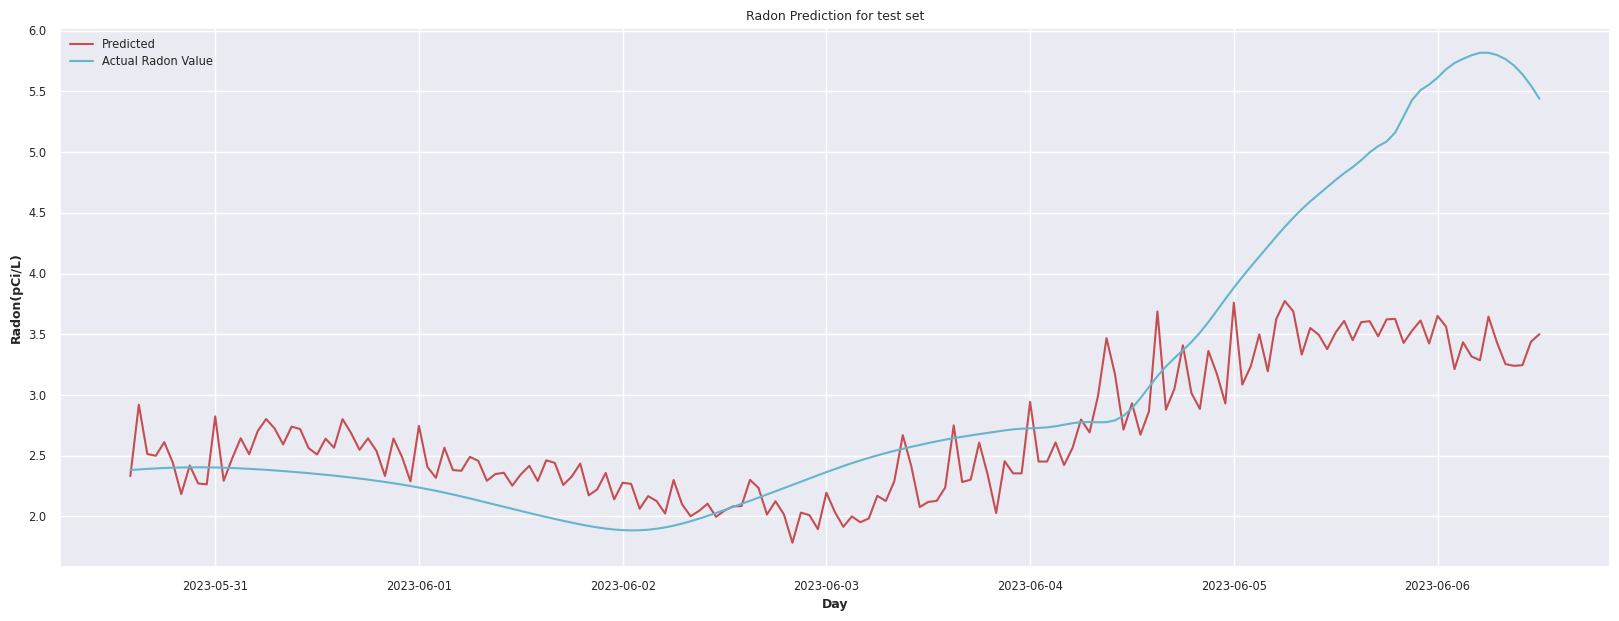

In [73]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()